In [5]:
from sklearn import metrics
from sklearn.cluster import KMeans
from active_semi_clustering.semi_supervised.pairwise_constraints import COPKMeans, PCKMeans, MPCKMeans
from active_semi_clustering.active.pairwise_constraints import ExampleOracle, ExploreConsolidate, MinMax
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from textwrap import wrap
from sklearn import preprocessing
import os
import random
from sklearn import preprocessing
from time import time
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

#Pre-process data set

def encode_columns(dataFrame, encode_cols):
    label_encoder = preprocessing.LabelEncoder()
    n_cols = len(dataFrame.columns)
    for col_cnt, col in enumerate(encode_cols):
        dataFrame.insert(n_cols + col_cnt, n_cols + col_cnt, label_encoder.fit_transform(dataFrame[col]))
    
    #Remove encoded columns
    for col_ind in encode_cols:
        dataFrame = dataFrame.drop(col_ind, axis=1)       
    return dataFrame
       
    

#Load and pre-process data set
def preprocess_dataset(file_name, p_header, drop_cols, cols_with_unknown, cast_cols, encode_cols):
    #print(file_name)
    df = pd.read_csv(file_name, header = p_header)
    
    #Drop non-informative columns
    if(len(drop_cols) > 0):
        df = df.drop(drop_cols, axis=1)
    
    #Replace unknown values
    if(len(cols_with_unknown) > 0): 
        for col in cols_with_unknown:       
            df = replace_unkown_values(df, col)

    #Convert columns
    if(len(cast_cols) > 0):
        for col_type in cast_cols:
            if (col_type[1] == 'int64'):
                df[col_type[0]] = pd.to_numeric(df[col_type[0]])
    
    #Encode columns
    if(len(encode_cols) > 0):
        df = encode_columns(df, encode_cols)
    
    #print(df.head(10))
    #print(df.dtypes)
    npdata = df.to_numpy()
    return npdata

def replace_unkown_values(dataF, col_label):
    filter_unknown =  dataF[col_label].str.contains('?', case = False, regex=False)
    max_val =  dataF.loc[filter_unknown == False, col_label].max()
    max_val = int(max_val) + 1
    dataF.loc[(filter_unknown == True),col_label] = max_val
    return dataF

def preprocessing_dataset(dataFrame):
    # label_encoder object knows how to understand word labels.
    label_encoder = preprocessing.LabelEncoder()
    # Encode labels in column 0
    dataFrame[36]= label_encoder.fit_transform(dataFrame[0])
    #Converting string type to numeric type
    all_fields = np.arange(1, 36)
    int_fields = [12,36]
    field_to_convert = [x for x in all_fields if x not in int_fields]
    for field in field_to_convert:
        dataFrame = replace_unkown_values(dataFrame, field)
        dataFrame.iloc[: , field] = pd.to_numeric(dataFrame.iloc[:, field])
    
    dataFrame = dataFrame.drop([0], axis = 1)
    return dataFrame


# Draw scatterplots of instances
def plot_scatterplot(Data, Labels, axs, title, cls_names, symb_marker, lbl_sizes):
    
    if(len(lbl_sizes) > 0):
        title_size = lbl_sizes[0]
        label_size = lbl_sizes[1]   
    
    unq_labels = np.unique(Labels)
    n_labels = len(unq_labels)
    max_item_lgn = 13
    col_lgn = 1
    if n_labels > max_item_lgn:
        col_lgn = 2

    colors = ['blue', 'red', 'green', 'yellow', 'black', 'maroon',   'lightgreen',
              'darkorange', 'darkkhaki', 'navy', 'darkseagreen', 'darkcyan', 
              'gold', 'deepskyblue', 'olive', 'slategrey', 'peru', 'royalblue', 'darkgoldenrod', 
              'indigo', 'tan', 'violet', 'sienna', 'purple', 'lightcoral', 'lightseagreen']

    for lbl_cnt, lbl in enumerate(unq_labels):
        axs.scatter(Data[Labels == lbl, 0], Data[Labels == lbl, 1], s=50,
                    label=cls_names[lbl_cnt], color = colors[lbl_cnt], marker = symb_marker)
    
    axs.set_title("\n".join(wrap(title, 40)), size = title_size)
    axs.grid(False)
    axs.legend(loc='best', ncol = col_lgn)
    axs.set_xlabel('PC1', fontsize = label_size)
    axs.set_ylabel('PC2', fontsize = label_size)
    
#Draw line-plots of metrics

def plot_NMI(Metrics, title, axs, lbl_sizes): 
    
    if(len(lbl_sizes) > 0):
        title_size = lbl_sizes[0]
        label_size = lbl_sizes[1] 
        
    axs.plot(Metrics[:, 0], Metrics[:,1],'bs-')
    axs.plot(Metrics[:, 2], Metrics[:,3],'ro-')
    axs.plot(Metrics[:, 4], Metrics[:,5],'g^-')
    axs.plot(Metrics[:, 6], Metrics[:,7],'mx-')
    axs.set_title("\n".join(wrap(title, 40)), size = title_size)
    axs.grid('On')
    axs.legend(('COPK-means', 'PCK-means', 'MPCK-means', 'K-means'))
    axs.set_xlabel('Number of pairwise constraints', fontsize = label_size)
    axs.set_ylabel('NMI', fontsize = label_size)

def plot_ARS(Metrics, title, axs, lbl_sizes): 
    
    if(len(lbl_sizes) > 0):
        title_size = lbl_sizes[0]
        label_size = lbl_sizes[1] 
        
    axs.plot(Metrics[:, 0], Metrics[:,1],'bs-')
    axs.plot(Metrics[:, 2], Metrics[:,3],'ro-')
    axs.plot(Metrics[:, 4], Metrics[:,5],'g^-')
    axs.plot(Metrics[:, 6], Metrics[:,7],'mx-')
    axs.set_title("\n".join(wrap(title, 40)), size = title_size)
    axs.grid('On')
    axs.legend(('COPK-means', 'PCK-means', 'MPCK-means', 'K-means'))
    axs.set_xlabel('Number of pairwise constraints', fontsize = label_size)
    axs.set_ylabel('ARS', fontsize = label_size)

def plot_ACC(Metrics, title, axs, lbl_sizes):  
    
    if(len(lbl_sizes) > 0):
        title_size = lbl_sizes[0]
        label_size = lbl_sizes[1] 
        
    axs.plot(Metrics[:, 0], Metrics[:,1],'bs-')
    axs.plot(Metrics[:, 2], Metrics[:,3],'ro-')
    axs.plot(Metrics[:, 4], Metrics[:,5],'g^-')
    axs.plot(Metrics[:, 6], Metrics[:,7],'mx-')
    axs.set_title("\n".join(wrap(title, 40)), size = title_size)
    axs.grid('On')
    axs.legend(('COPK-means', 'PCK-means', 'MPCK-means', 'K-means'))
    axs.set_xlabel('Number of pairwise constraints', fontsize = label_size)
    axs.set_ylabel('Accuracy', fontsize = label_size)

#Calculating clustering accuracy
def accuracy(true_row_labels, predicted_row_labels):
    cm = confusion_matrix(true_row_labels, predicted_row_labels)
    indexes = linear_sum_assignment(_make_cost_m(cm))
    sort_ind = sorted(indexes, key=lambda x: x[0])    
    js = sort_ind[1]
    cm2 = cm[:, js]
    acc = np.trace(cm2) / np.sum(cm2)
    return acc

def clustering_accuracy(n_ML, n_CL, n_instances):
    total_decisions = n_instances * (n_instances -1)/2
    acc = (n_ML+n_CL)/total_decisions
    return acc

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

def avg_values(all_metrics):
    constraints = np.unique(all_metrics[:, 0]) #Number of constraints
    n_algorithms = 4
    #print('metrics: ', all_metrics)
    result_values = np.empty((constraints.shape[0], n_algorithms))

    for i, constraint in enumerate(constraints):
        result_values[i,0] = np.mean(all_metrics[all_metrics[:, 0] == constraint,1])
        result_values[i,1] = np.mean(all_metrics[all_metrics[:, 2] == constraint,3])
        result_values[i,2] = np.mean(all_metrics[all_metrics[:, 4] == constraint,5])
        result_values[i,3] = np.mean(all_metrics[all_metrics[:, 6] == constraint,7])
        
    new_metrics = np.hstack((constraints.reshape((-1,1)), result_values[:,0].reshape((-1,1)), 
                             constraints.reshape((-1, 1)), result_values[:,1].reshape((-1,1)),
                             constraints.reshape((-1, 1)), result_values[:,2].reshape((-1,1)),
                             constraints.reshape((-1, 1)), result_values[:,3].reshape((-1,1))
                            ))
    return new_metrics  

def get_random_sample(p_Data, p_Labels, n_sample):
    n_rows, _ = p_Data.shape
    rand_sample_ind = np.random.choice(n_rows, n_sample, replace = False)

    return p_Data[rand_sample_ind], p_Labels[rand_sample_ind]

def get_random_indexes(p_Data):
    n_rows, _ = p_Data.shape
    rand_sample_ind = np.random.choice(n_rows, n_rows, replace = False)
    
    return rand_sample_ind

# Get constraints of animal data sets from videos
def get_video_constraints(Data, Video_frames, n_constraints):
    ML = []
    CL = []
    n_elem = len(Video_frames) #Number of frames
    random_ind = get_random_indexes(Data) #Getting random indexes

    i = 0
    j = 0
    rand_i = 0
    rand_j = 0
    
    while((i < n_elem) and (len(CL) < n_constraints)):
        rand_i = random_ind[i]
        while((j < n_elem) and (len(CL) < n_constraints)):
            rand_j = random_ind[j]
            if (rand_i!=rand_j):
                if (Video_frames[rand_i] == Video_frames[rand_j]):
                    CL.append((rand_i,rand_j))

                
            j = j + 1
        j = 0
        i = i + 1
            
    #print('ml cnt: ', len(ML))
    #print('cl cnt: ', len(CL))
    #print('ML =', ML)
    #print('CL =', CL)
    return ML, CL    
    
# Get constraints
def get_constraints(Data, Labels, n_constraints):
    ML = []
    CL = []
    n_elem = len(Labels) #Number of labels
    random_ind = get_random_indexes(Data) #Getting random indexes
    
    i = 0
    j = 0
    rand_i = 0
    rand_j = 0
    
    while((i < n_elem) and ((len(ML) + len(CL)) < n_constraints)):
        rand_i = random_ind[i]
        while((j < n_elem) and ((len(ML) + len(CL)) < n_constraints)):
            rand_j = random_ind[j]
            if (rand_i!=rand_j):
                if (Labels[rand_i] == Labels[rand_j]):
                    ML.append((rand_i,rand_j))
                else:             
                    CL.append((rand_i,rand_j))
                
            j = j + 1
        j = 0
        i = i + 1
            
    #print('ml cnt: ', len(ML))
    #print('cl cnt: ', len(CL))
    #print('ML =', ML)
    #print('CL =', CL)
    return ML, CL

# Pairwise clustering
def pairwise_clustering(Data, Labels, Video_frames, arr_n_constraints):
    NMI_cls = []
    ARS_cls = []
    ACC_cls = []
    all_NMI = []
    all_ARS = []
    all_ACC = []
    
    n_unq_lbl = len(np.unique(Labels))
    cls_alg = [] # accumlate the algorithms
    cls_alg.append(COPKMeans(n_clusters=n_unq_lbl))
    cls_alg.append(PCKMeans(n_clusters=n_unq_lbl))
    cls_alg.append(MPCKMeans(n_clusters=n_unq_lbl))
    cls_alg.append(KMeans(n_clusters=n_unq_lbl, random_state=5))

    n_cls = len(cls_alg)
    n_frames = len(Video_frames)
    n_ML = 0 # Number of cannot-link constraints
    n_CL = 0 # Number of must-link constraints
    n_instances = Data.shape[0]
    for n_const, const in enumerate(arr_n_constraints): 
        
        if (n_frames> 0):
            ML, CL = get_video_constraints(Data, Video_frames, const)
        else:    
            ML, CL = get_constraints(Data, Labels, const)
         
        n_ML = len(ML)
        n_CL = len(CL)     
        NMI_cls = []
        ARS_cls = []
        ACC_cls = []
        
        for clus_cnt, clusterer in enumerate(cls_alg):
            #print('clus cnt: ', clus_cnt)
            if(clus_cnt < n_cls-1):
                clusterer.fit(Data, ml=ML, cl=CL) 
            else:
                clusterer.fit(Data)
                
            ARS = metrics.adjusted_rand_score(Labels, clusterer.labels_)
            NMI = normalized_mutual_info_score(Labels, clusterer.labels_)
            clust_accuracy = accuracy(Labels, clusterer.labels_)

            if len(NMI_cls) == 0:
                NMI_cls = (const, round(NMI, 4))
                ARS_cls = (const, round(ARS, 4))
                ACC_cls = (const, round(clust_accuracy, 4))
            else:
                NMI_cls = np.hstack((NMI_cls, (const, round(NMI, 4))))
                ARS_cls = np.hstack((ARS_cls, (const, round(ARS, 4))))
                ACC_cls = np.hstack((ACC_cls, (const, round(clust_accuracy, 4))))

        all_NMI.append(NMI_cls)
        all_ARS.append(ARS_cls)
        all_ACC.append(ACC_cls)
  
    all_NMI = np.array(all_NMI)
    all_ARS = np.array(all_ARS)
    all_ACC = np.array(all_ACC)
    #print('NMI: ', all_NMI)  
    #print('METRICS: ', all_ARS)
    #all_NMI = avg_values(all_NMI)
    #all_ARS = avg_values(all_ARS)
    
    return all_NMI, all_ARS, all_ACC

#Reduce dimensions of Data set using PCA
def reduce_dimensionality(Data, n_comp):
    pca = PCA(n_components=n_comp)
    new_Data = pca.fit(Data).transform(Data)
    return new_Data

#Running n experiments
def run_experiments(Data_r, Labels, Video_frames, arr_n_constraints, n_runs, order_random):
    all_NMI = []
    all_ARS = []
    all_ACC = []
    n_inst = Data_r.shape[0]
    
    for i in range(n_runs):
        print('Run # ', i)
        if order_random :
            Data_ord, Labels_ord = get_random_sample(Data_r, Labels, n_inst)
        else:
            Data_ord = Data_r
            Labels_ord = Labels
            
        sample_NMI, sample_ARS, sample_ACC = pairwise_clustering(Data_ord, Labels_ord, 
                                                        Video_frames, arr_n_constraints)
        all_NMI.extend(sample_NMI)
        all_ARS.extend(sample_ARS)
        all_ACC.extend(sample_ACC)

    all_NMI = np.array(all_NMI)
    all_ARS = np.array(all_ARS)
    all_ACC = np.array(all_ACC)

    all_NMI = avg_values(all_NMI)
    all_ARS = avg_values(all_ARS)
    all_ACC = avg_values(all_ACC)
    
    return all_NMI, all_ARS, all_ACC


In [ ]:
from time import time
import matplotlib.pyplot as plt
import os
from sklearn import datasets

figure, axs = plt.subplots(6, 4, figsize = (25,35))
plt.subplots_adjust(hspace = 0.5) 
plt.suptitle('Results', fontsize=16, y=0.92)
folder = 'DataSets'
label_sizes = [14, 12] #Title and axis label size.
video_frames = []
n_comp = 2 # Number of principal components = [0,1] 
feat_plot = [0,1] # Features to plot
#Reading Iris Dataset
titles = ['Comparison of NMI on Iris Data Set', 'Comparison of ARS on Iris Data Set', 
          'Comparison of Accuracy on Iris Data Set']
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints
cls_names = ['Iris Setosa', 'Iris Versicolour', 'Iris Virginica']
symb_marker = 'o'
n_sample = 150 #Total number of instances
print('Iris Data Set')
Data, Labels = datasets.load_iris(return_X_y=True)
Data_r = reduce_dimensionality(Data, n_comp)

#Data, Labels = get_random_sample(Data, Labels, n_sample) #Order randomly the dataset
plot_scatterplot(Data_r, Labels, axs[0,0], 'Scatterplot of Iris Data Set', 
                 cls_names, symb_marker, label_sizes)

all_NMI, all_ARS, all_ACC = pairwise_clustering(Data, Labels, video_frames, arr_n_constraints)
plot_NMI(all_NMI, titles[0], axs[0,1], label_sizes)
plot_ARS(all_ARS, titles[1], axs[0,2], label_sizes)
plot_ACC(all_ACC, titles[2], axs[0,3], label_sizes)

Iris Dataset
Wine Dataset
Diabetes Dataset
Breast cancer Dataset
Pen-digits Dataset
Letter-recognition Dataset


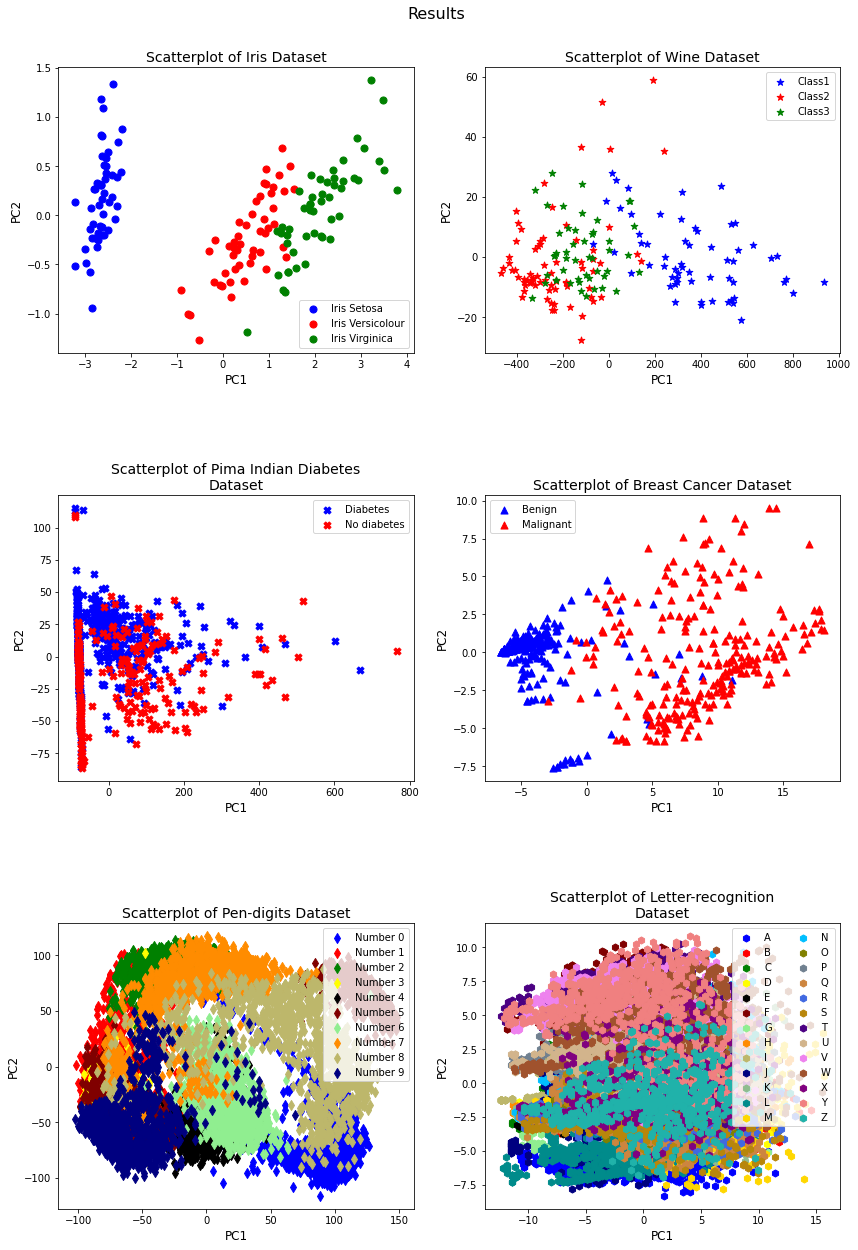

In [2]:
from sklearn import datasets
#Plotting scatterplot of real Datasets

figure, axs = plt.subplots(3, 2, figsize = (14,21))
plt.subplots_adjust(hspace = 0.5) 
plt.suptitle('Results', fontsize=16, y=0.92)
folder = 'DataSets'
label_sizes = [14, 12] #Title and axis label size.
video_frames = []
n_comp = 2 # Numbber of principal components

print('Iris Dataset')
Data_iris, Labels_iris = datasets.load_iris(return_X_y=True)
cls_names = ['Iris Setosa', 'Iris Versicolour', 'Iris Virginica']
symb_marker = 'o'

Data_r = reduce_dimensionality(Data_iris, n_comp)

plot_scatterplot(Data_r, Labels_iris, axs[0,0], 'Scatterplot of Iris Dataset', 
                 cls_names, symb_marker, label_sizes)

print('Wine Dataset')
src = os.path.join(folder, 'wine.data')
npdata = preprocess_dataset(src, None, [], [], [], [])
Data_wine = npdata[:, 1:]
Labels_wine = npdata[:,0] 
n_sample = 178 #Total number of instances
cls_names = ['Class1', 'Class2', 'Class3']
symb_marker = '*'

Data_r = reduce_dimensionality(Data_wine, n_comp) 

plot_scatterplot(Data_r, Labels_wine, axs[0,1], 'Scatterplot of Wine Dataset', 
                 cls_names, symb_marker, label_sizes)

print('Diabetes Dataset')

src = os.path.join(folder, 'diabetes.csv')
npdata = preprocess_dataset(src, 0, [], [], [], [])
Data_diabetes = npdata[:, :-1]
Labels_diabetes = npdata[:,-1] 
cls_names = ['Diabetes', 'No diabetes']
symb_marker = 'X'

Data_r = reduce_dimensionality(Data_diabetes, n_comp) 

plot_scatterplot(Data_r, Labels_diabetes, axs[1,0], 'Scatterplot of Pima Indian Diabetes Dataset', 
                 cls_names, symb_marker, label_sizes)

print('Breast cancer Dataset')
src = os.path.join(folder, 'breast-cancer-wisconsin.data')
npdata = preprocess_dataset(src, None, [0], [6], [(6, 'int64')], [])
Data_BC = npdata[:, :-1]
Labels_BC = npdata[:,-1] 
cls_names = ['Benign', 'Malignant']
symb_marker = '^'

Data_r = reduce_dimensionality(Data_BC, n_comp) 

plot_scatterplot(Data_r, Labels_BC, axs[1,1], 'Scatterplot of Breast Cancer Dataset', 
                 cls_names, symb_marker, label_sizes)

print('Pen-digits Dataset')
src = os.path.join(folder, 'pendigits.tra')

npdata_trn = preprocess_dataset(src, None, [], [], [], [])
Data_Trn = npdata_trn[:, :-1] 
Labels_Trn = npdata_trn[:,-1] 

src = os.path.join(folder, 'pendigits.tes')
npdata_tst = preprocess_dataset(src, None, [], [], [], [])
Data_Tst = npdata_tst[:, :-1] 
Labels_Tst = npdata_tst[:,-1] 

Data_PD = np.vstack((Data_Trn, Data_Tst))
Labels = np.vstack((Labels_Trn.reshape((-1,1)), Labels_Tst.reshape(-1,1)))
Labels_PD = Labels.flatten()

cls_names = ['Number 0', 'Number 1', 'Number 2', 'Number 3', 'Number 4', 'Number 5', 'Number 6', 
             'Number 7', 'Number 8', 'Number 9']
symb_marker = 'd' # Marker


Data_r = reduce_dimensionality(Data_PD, n_comp) 

plot_scatterplot(Data_r, Labels_PD, axs[2,0], 'Scatterplot of Pen-digits Dataset', 
                 cls_names, symb_marker, label_sizes)

print('Letter-recognition Dataset')
src = os.path.join(folder, 'letter-recognition.data')
encode_cols = [0]
npdata = preprocess_dataset(src, None, [], [], [], encode_cols)
Data_LR = npdata[:, :-1] 
Data_LR = np.array(Data_LR, dtype =float)
Labels_LR = npdata[:,-1] 
cls_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
            'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
symb_marker = 'h' #Marker

Data_r = reduce_dimensionality(Data_LR, n_comp) 

plot_scatterplot(Data_r, Labels_LR, axs[2,1], 'Scatterplot of Letter-recognition Dataset', 
                 cls_names, symb_marker, label_sizes)

#Initialisation of global variables

subp_width = 25 #Width of subplots area
subp_height = 6 #Heigth of subplots area
subp_title_size = 20 #Size of subplots title
subp_hspace = 0.5
y_title = 1.05 # Y-position of subplots title

label_sizes = [16, 14] #Title and axis label size.
video_frames = []
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints
n_runs = 20 #Number of experiment runs

In [ ]:
import matplotlib.pyplot as plt
import os
from sklearn import datasets

n_sample = 150 # Total number of instances
order_random = True #Order randomly instances for every run
#Setting subplots
figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Iris Dataset', fontsize=subp_title_size, y=y_title)

#Clustering Iris Dataset
titles = ['Comparison of NMI on Iris Dataset', 'Comparison of ARS on Iris Dataset', 
          'Comparison of Accuracy on Iris Dataset']

print('Iris Dataset')

s_time_clus = time()

all_NMI, all_ARS, all_ACC = run_experiments(Data_iris, Labels_iris, video_frames, arr_n_constraints, 
                                            n_runs, order_random)

plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

e_time_clus = time()
print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

Wine Dataset
Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :67.8859  seconds


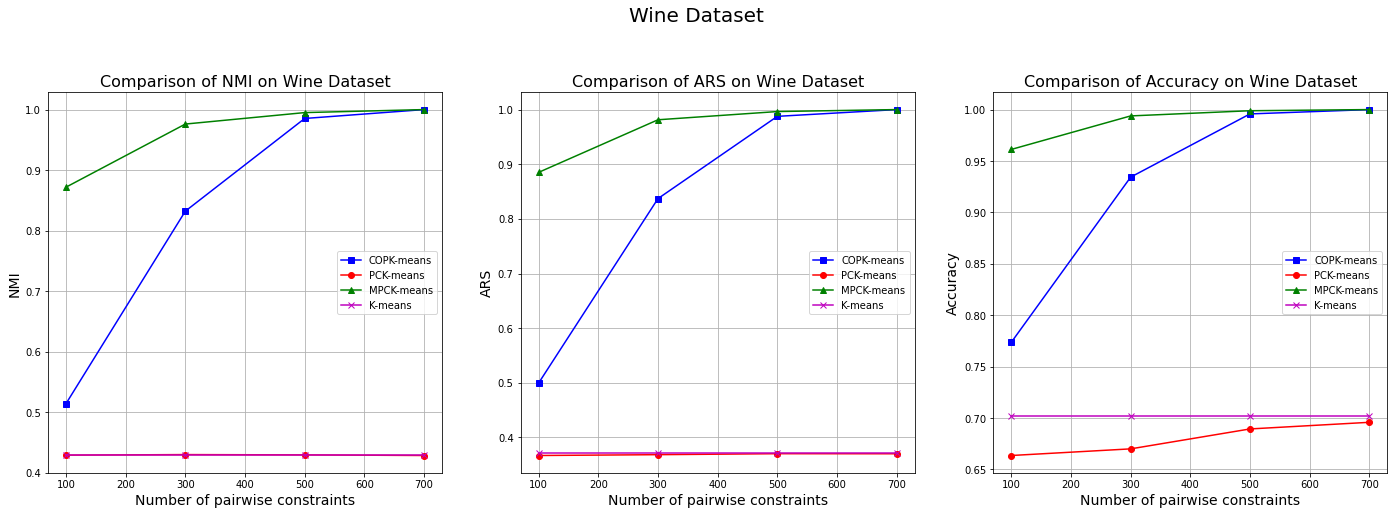

In [31]:
#Setting subplots
figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Wine Dataset', fontsize=subp_title_size, y=y_title)

#Clustering wine Dataset

print('Wine Dataset')

titles = ['Comparison of NMI on Wine Dataset', 'Comparison of ARS on Wine Dataset', 
          'Comparison of Accuracy on Wine Dataset']

order_random = True #Order randomly instances for every run

s_time_clus = time()

n_sample = 178
spl_Data, spl_Labels = get_random_sample(Data_wine, Labels_wine, n_sample)

all_NMI, all_ARS, all_ACC = run_experiments(Data_wine, Labels_wine, video_frames, arr_n_constraints, 
                                            n_runs, order_random)

plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

e_time_clus = time()
print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

Diabetes Dataset
Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :1103.6716  seconds


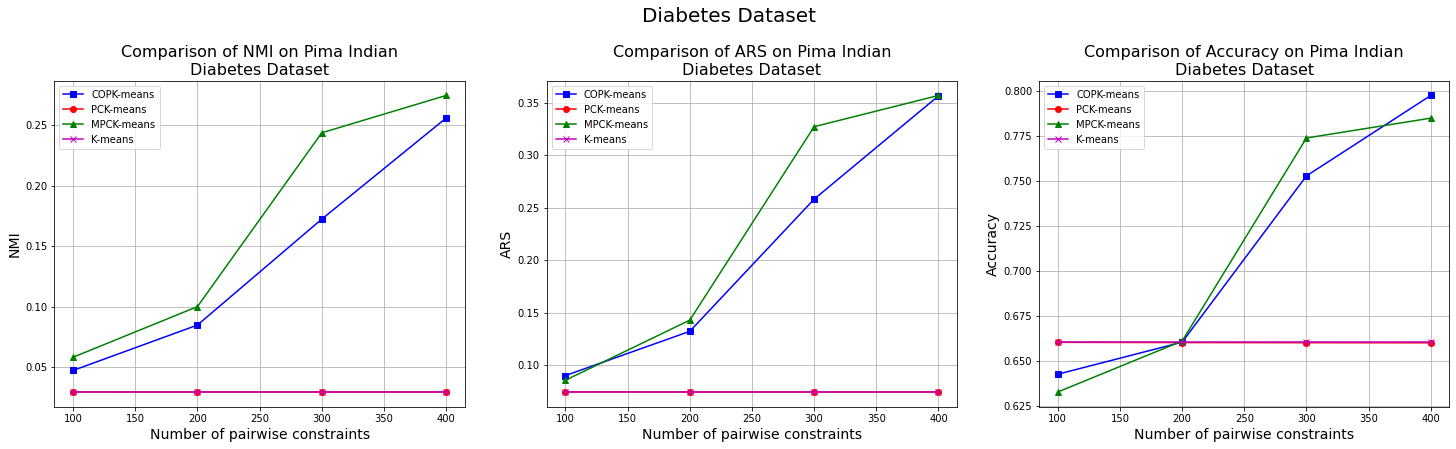

In [7]:
#Setting subplots
figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Diabetes Dataset', fontsize=subp_title_size, y=y_title)

#Clustering Diabetes Dataset
print('Diabetes Dataset')

titles = ['Comparison of NMI on Pima Indian Diabetes Dataset', 
          'Comparison of ARS on Pima Indian Diabetes Dataset', 
          'Comparison of Accuracy on Pima Indian Diabetes Dataset']
order_random = False

s_time_clus = time()

all_NMI, all_ARS, all_ACC = run_experiments(Data_diabetes, Labels_diabetes, video_frames, arr_n_constraints
                                            , n_runs, order_random)

plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

e_time_clus = time()
print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

Breast cancer Dataset
Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :572.7812  seconds


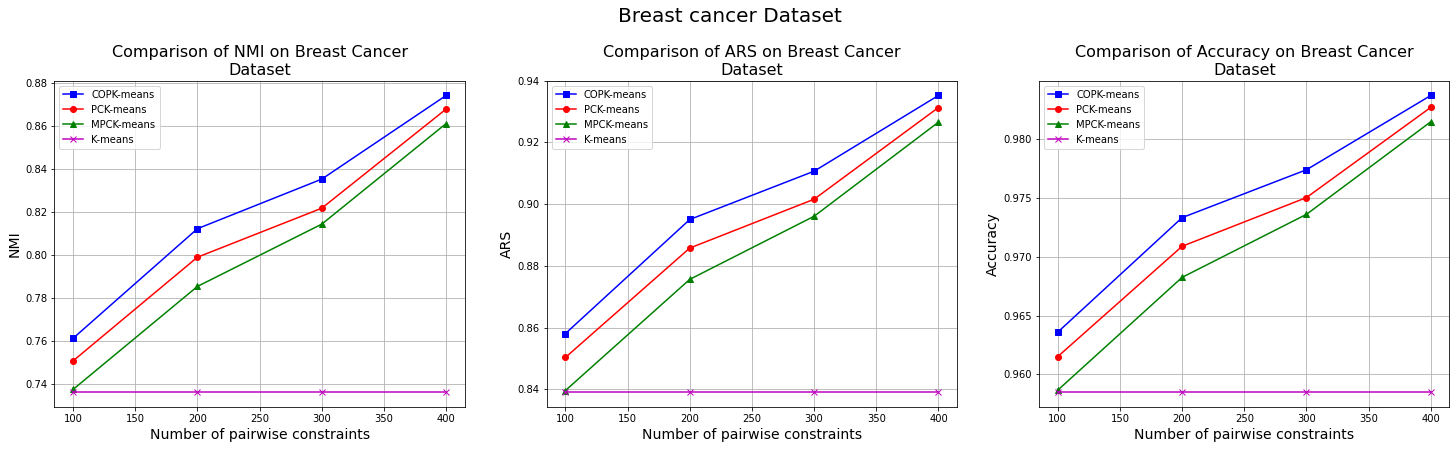

In [8]:
#Setting subplots
figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Breast cancer Dataset', fontsize=subp_title_size, y=y_title)

#Reading breast cancer Dataset

print('Breast cancer Dataset')

titles = ['Comparison of NMI on Breast Cancer Dataset', 'Comparison of ARS on Breast Cancer Dataset', 
          'Comparison of Accuracy on Breast Cancer Dataset']

order_random = False

s_time_clus = time()

all_NMI, all_ARS, all_ACC = run_experiments(Data_BC, Labels_BC, video_frames, arr_n_constraints, 
                                            n_runs, order_random)

plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

e_time_clus = time()
print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

Pen-digits Dataset
Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :1963.9053  seconds


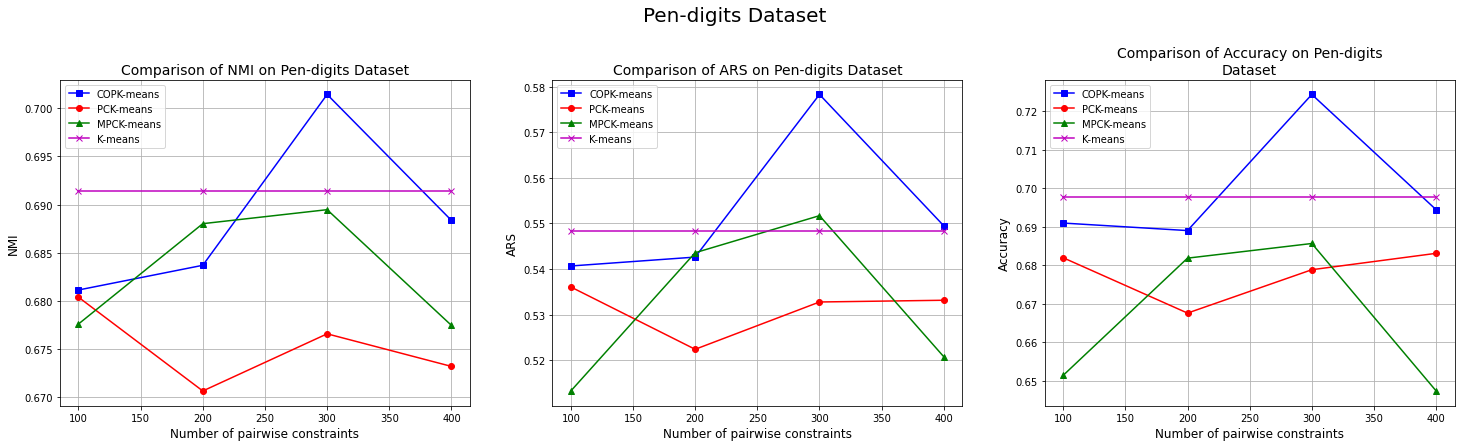

In [11]:
#Setting up subplots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pen-digits Dataset', fontsize=subp_title_size, y=y_title)
folder = 'DataSets'
label_sizes = [14, 12] #Title and axis label size.
video_frames = []

#Reading Pen-digits Dataset
print('Pen-digits Dataset')
src = os.path.join(folder, 'pendigits.tra')

npdata_trn = preprocess_dataset(src, None, [], [], [], [])
Data_Trn = npdata_trn[:, :-1] 
Labels_Trn = npdata_trn[:,-1] 

src = os.path.join(folder, 'pendigits.tes')
npdata_tst = preprocess_dataset(src, None, [], [], [], [])
Data_Tst = npdata_tst[:, :-1] 
Labels_Tst = npdata_tst[:,-1] 

Data = np.vstack((Data_Trn, Data_Tst))
Labels = np.vstack((Labels_Trn.reshape((-1,1)), Labels_Tst.reshape(-1,1)))
Labels = Labels.flatten()
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints

titles = ['Comparison of NMI on Pen-digits Dataset', 'Comparison of ARS on Pen-digits Dataset', 
          'Comparison of Accuracy on Pen-digits Dataset']
n_runs = 20
n_sample = 1000

s_time_clus = time()

all_NMI = []
all_ARS = []
all_ACC = []

for i in range(n_runs): 
    print('Run # ', i)
    spl_Data, spl_Labels = get_random_sample(Data_PD, Labels_PD, n_sample)
    sample_NMI, sample_ARS, sample_ACC = pairwise_clustering(spl_Data, spl_Labels, 
                                                             video_frames, arr_n_constraints)
    all_NMI.extend(sample_NMI)
    all_ARS.extend(sample_ARS)
    all_ACC.extend(sample_ACC)

all_NMI = np.array(all_NMI)
all_ARS = np.array(all_ARS)
all_ACC = np.array(all_ACC)

all_NMI = avg_values(all_NMI)
all_ARS = avg_values(all_ARS)
all_ACC = avg_values(all_ACC)

plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

Letter-recognition Data Set
Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :2281.3579  seconds


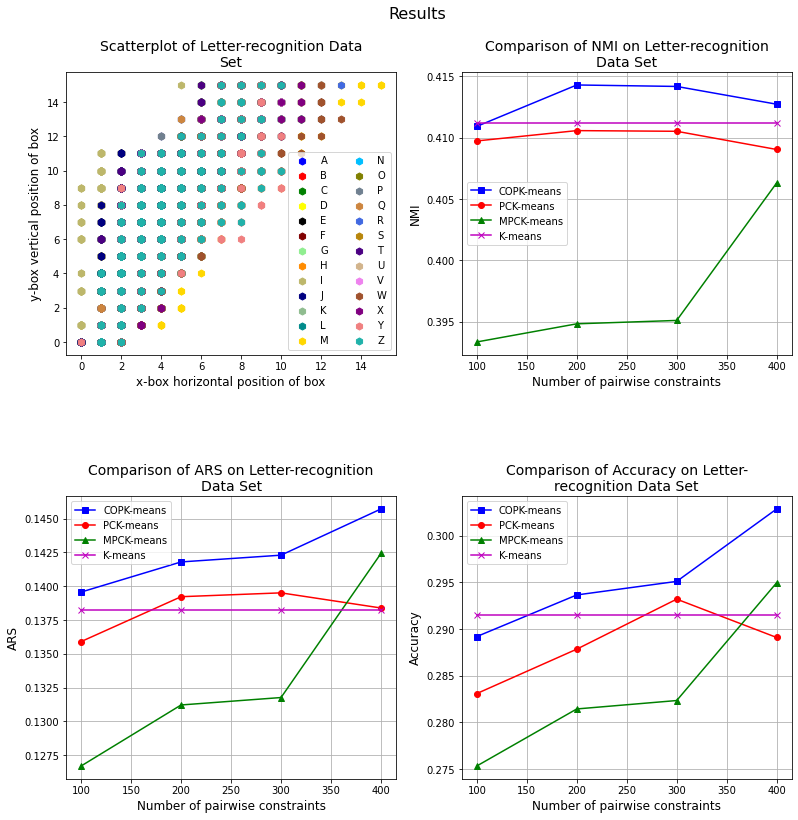

In [4]:
#Setting up subplots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Results', fontsize=subp_title_size, y=y_title)
folder = 'DataSets'
label_sizes = [14, 12] #Title and axis label size.
video_frames = []

#Reading Letter-recognition Dataset

print('Letter-recognition Dataset')
src = os.path.join(folder, 'letter-recognition.data')
encode_cols = [0]
npdata = preprocess_dataset(src, None, [], [], [], encode_cols)
Data = npdata[:, :-1] 
Data = np.array(Data, dtype =float)
Labels = npdata[:,-1] 
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints
titles = ['Comparison of NMI on Letter-recognition Dataset', 'Comparison of ARS on Letter-recognition Dataset', 
          'Comparison of Accuracy on Letter-recognition Dataset']
n_runs = 20
n_sample = 1000

s_time_clus = time()

feat_plot = [0,1] #Features to plot
lbl_names = ['x-box horizontal position of box', 'y-box vertical position of box', 'width of box',
            'height of box', 'onpix total', 'x-bar mean x of on pixels in box', 
            'y-bar mean y of on pixels in box', 'x2bar mean x variance', 'y2bar mean y variance',
            'xybar mean x y correlation', 'x2ybr mean of x * x * y', 'xy2br mean of x * y * y',
            'x-ege mean edge count left to right', 'xegvy correlation of x-ege with y', 
            'y-ege mean edge count bottom to top', 'yegvx correlation of y-ege with x']

cls_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
            'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
symb_marker = 'h' #Index marker from markers array

plot_scatterplot(Data, Labels, axs[0,0], 'Scatterplot of Letter-recognition Dataset', 
                 feat_plot, lbl_names, cls_names, symb_marker, label_sizes)
    
all_NMI = []
all_ARS = []
all_ACC = []
for i in range(n_runs): 
    print('Run # ', i)
    spl_Data, spl_Labels = get_random_sample(Data, Labels, n_sample)
    sample_NMI, sample_ARS, sample_ACC = pairwise_clustering(spl_Data, spl_Labels, 
                                                             video_frames, arr_n_constraints)
    all_NMI.extend(sample_NMI)
    all_ARS.extend(sample_ARS)
    all_ACC.extend(sample_ACC)

all_NMI = np.array(all_NMI)
all_ARS = np.array(all_ARS)
all_ACC = np.array(all_ACC)

all_NMI = avg_values(all_NMI)
all_ARS = avg_values(all_ARS)
all_ACC = avg_values(all_ACC)

plot_NMI(all_NMI, titles[0], axs[0,1], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1,0], label_sizes)
plot_ACC(all_ACC, titles[2], axs[1,1], label_sizes)
e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

(1000, 2)
(1000,)
Interleaving Half Circles Dataset
(1000, 2)
(1000,)
Circles Dataset
(1000, 2)
(1000,)
Blobs with anisotropicly distributed data
(1000, 4)
(1000,)
Gaussian divided into four quantiles
(1000, 8)
(1000,)
Multi-class, two informative features, one cluster per class
(1000, 10)
(1000,)
Blobs with equal variance
(1000, 16)
(1000,)
Blobs with unequal variance


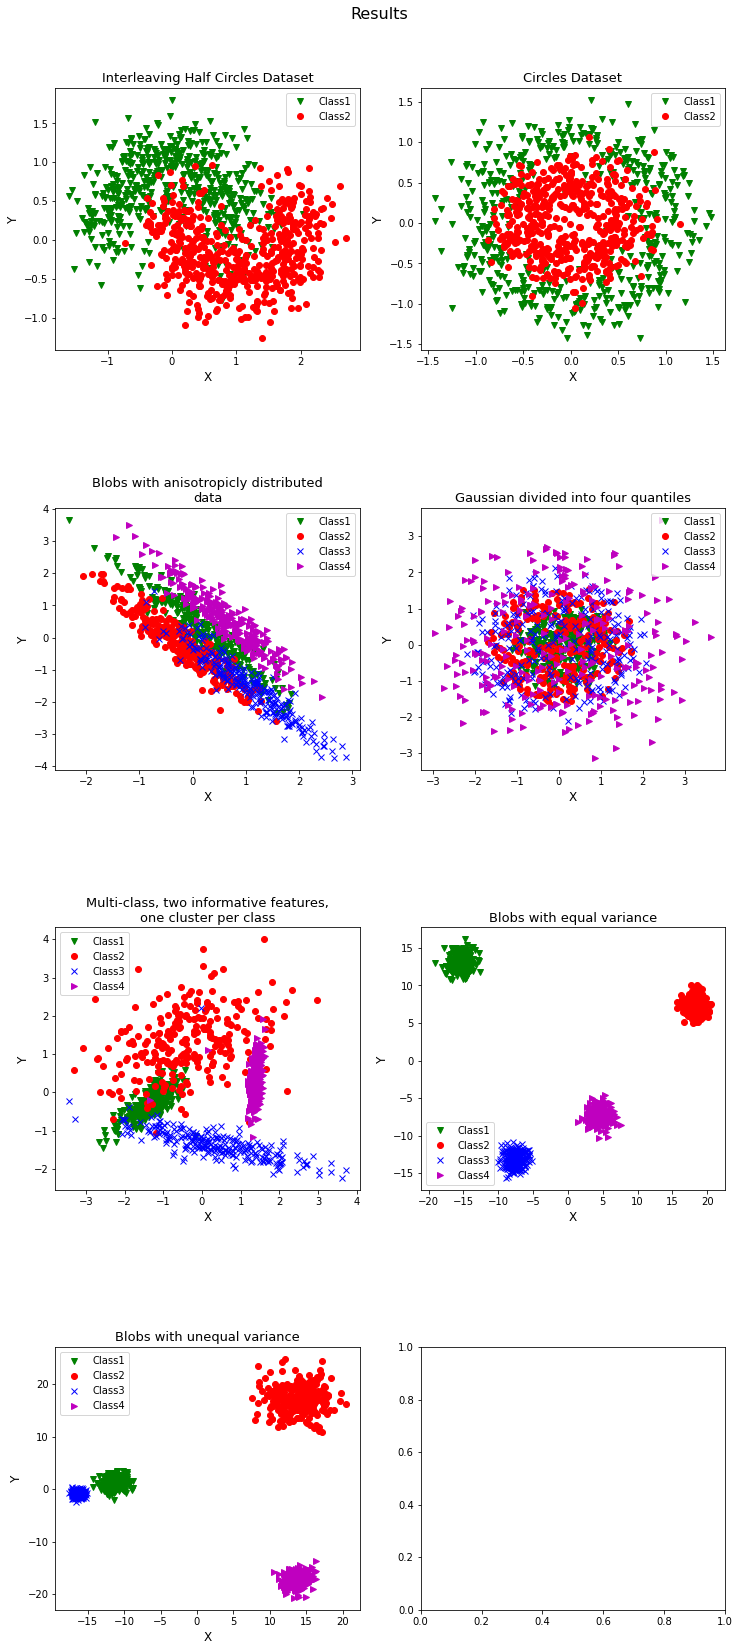

In [5]:
from sklearn.datasets import make_moons, make_circles, make_blobs, make_classification, make_gaussian_quantiles

def plot_scatterplot_toy_ds(Data, Labels, axs, title, lbl_sizes):
    
    if(len(lbl_sizes) > 0):
        title_size = lbl_sizes[0]
        label_size = lbl_sizes[1] 
        
    markers = ['gv', 'ro', 'bx', 'm>']
    unq_lbls = np.unique(Labels)
    for lbl_cnt, label in enumerate(unq_lbls):
         axs.plot(Data[Labels == label,0],Data[Labels == label,1], markers[lbl_cnt])

    axs.set_title("\n".join(wrap(title, 40)), size = title_size)
    #axs.grid('On')
    axs.legend(('Class1', 'Class2', 'Class3', 'Class4'))
    axs.set_xlabel('X', fontsize = label_size)
    axs.set_ylabel('Y', fontsize = label_size)

def anisotropicly_distributed_data(n_sample, n_feat):
    a_centers = [[1, 1], [-1, -1], [1, -1], [3,3]]
    X, y = make_blobs(n_samples=n_sample, n_features = n_feat, centers = a_centers, random_state=170)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)
    return aniso

#Setting the subplots
figure, axs = plt.subplots(4, 2, figsize = (12,28))
plt.subplots_adjust(hspace = 0.6) 
figure.suptitle('Results', fontsize=16, y = 0.92)


centers = [[1, 1], [-1, -1], [1, -1], [3,3]]
n_sample = 1000
datasets = [
    [make_moons(n_samples = n_sample, noise=0.3, random_state=0), 0, 0],
    [make_circles(n_samples = n_sample, noise=0.2, factor=0.5, random_state=1), 0 ,1],
    [anisotropicly_distributed_data(n_sample, 2), 1, 0],
    [make_gaussian_quantiles(n_samples = n_sample, n_features=4, n_classes=4), 1, 1],
    [make_classification(n_samples = n_sample, n_features=8, n_redundant=0, n_informative=2, 
                        n_clusters_per_class=1, n_classes=4), 2, 0], 
    [make_blobs(n_samples=n_sample, n_features = 10, centers=4, cluster_std=0.9), 2, 1],
    [make_blobs(n_samples=n_sample, n_features = 16, centers=4, cluster_std=[1.0, 2.5, 0.5, 1.0], 
               random_state=170), 3, 0]
]

name_ds = ['Interleaving Half Circles Dataset', 'Circles Dataset', 'Blobs with anisotropicly distributed data',
           'Gaussian divided into four quantiles', 'Multi-class, two informative features, one cluster per class', 
           'Blobs with equal variance', 'Blobs with unequal variance']

label_sizes = [13, 12]
n_feat = 0 #Number of features
n_comp = 2 #Number of principal components

Datasets = []

for ds_cnt, ds in enumerate(datasets):
    Data, Labels = ds[0]
    print(Data.shape)
    print(Labels.shape)
    un_lbl = np.unique(Labels)
    n_feat = Data.shape[1]
    
    if n_feat > 2 :
        Data_r = reduce_dimensionality(Data, n_comp) 
    else:
        Data_r = Data
    Datasets.append([Data, Labels])

    plot_scatterplot_toy_ds(Data_r, Labels, axs[ds[1], ds[2]], name_ds[ds_cnt], label_sizes)
    print(name_ds[ds_cnt])
#print(Datasets[0][0])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
from time import time
 
    
figure, axs = plt.subplots(7, 3, figsize = (22,35))
plt.subplots_adjust(hspace = 0.5) 
figure.suptitle('Results', fontsize=16, y = 0.92)

plot_titles = ['Comparison of NMI on ', 'Comparison of ARS on ', 'Comparison of Accuracy on ']
Video_frames = []
label_sizes = [13, 12]
arr_n_constraints = [100, 200, 300, 400] #Array of number of constraints   
n_runs = 1
order_random = False 

for ds_cnt, ds in enumerate(Datasets):
    Data, Labels = ds 
    un_lbl = np.unique(Labels)

    s_time_clus = time()

    all_NMI, all_ARS, all_ACC = run_experiments(Data, Labels, Video_frames, arr_n_constraints
                                            , n_runs, order_random)

    plot_NMI(all_NMI, plot_titles[0] + name_ds[ds_cnt], axs[ds_cnt, 0], label_sizes)
    plot_ARS(all_ARS, plot_titles[1] + name_ds[ds_cnt], axs[ds_cnt, 1], label_sizes)
    plot_ACC(all_ACC, plot_titles[2] + name_ds[ds_cnt], axs[ds_cnt, 2], label_sizes)

    e_time_clus = time()
    print(name_ds[ds_cnt])
    print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")


Run #  0


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import Counter

def load_label_files(Trn_lbl_file, Tst_lbl_file, class_labels_file, title):

    folder = 'Train_test_files'
    src = os.path.join(folder, Trn_lbl_file)
    df = pd.read_csv(src, header=None)
    df = df.iloc[:, 0].str.rstrip()
    Trn_cls_names = df.to_numpy()
    src = os.path.join(folder, Tst_lbl_file)
    df = pd.read_csv(src, header=None)
    df = df.iloc[:, 0].str.rstrip()
    Tst_cls_names = df.to_numpy()
    print(Trn_cls_names.shape)
    print(Tst_cls_names.shape)
    cls_names = np.vstack((Trn_cls_names.reshape((-1, 1)), Tst_cls_names.reshape((-1, 1))))

    src = os.path.join(folder, class_labels_file)
    cls_labels = pd.read_csv(src, header=None).to_numpy()
    labels = np.hstack((cls_labels.reshape((-1, 1)), cls_names[:,0].reshape(-1, 1)))
    new_labels = tuple(map(tuple, labels))
    unq_lbl = sorted(set(new_labels))
    unq_lbl = np.array(unq_lbl)
    print(title)
    print(unq_lbl)
    return unq_lbl[:, 1]


Trn_file = 'Train_BB_Pigs_49651_960_540_500f.csv'
Tst_file = 'Test_BB_Pigs_49651_960_540_500f.csv'
Lbl_file = 'Pigs_49651_960_540_500f_Labels.csv'
title = 'Pigs label names'
pigs_lbl_names = load_label_files(Trn_file, Tst_file, Lbl_file, title)
Trn_file = 'Train_BB_Koi_5652_952_540.csv'
Tst_file = 'Test_BB_Koi_5652_952_540.csv'
Lbl_file = 'Koi_5652_952_540_Labels.csv'
title = 'Koi fish label names'
koi_lbl_names = load_label_files(Trn_file, Tst_file, Lbl_file, title)
Trn_file = 'Train_BB_Pigeons_8234_1280_720.csv'
Tst_file = 'Test_BB_Pigeons_8234_1280_720.csv'
Lbl_file = 'Pigeons_8234_1280_720_Labels.csv'
title = 'Pigons on the curb - Label names'
pigeons_curb_lbl_names = load_label_files(Trn_file, Tst_file, Lbl_file, title)
Trn_file = 'Train_BB_Pigeons_4927_960_540_600f.csv'
Tst_file = 'Test_BB_Pigeons_4927_960_540_600f.csv'
Lbl_file = 'Pigeons_4927_960_540_600f_Labels.csv'
title = 'Pigeons on the ground - Label names'
pigeons_ground_lbl_names = load_label_files(Trn_file, Tst_file, Lbl_file, title)
Trn_file = 'Train_BB_Pigeons_29033_960_540_300f.csv'
Tst_file = 'Test_BB_Pigeons_29033_960_540_300f.csv'
Lbl_file = 'Pigeons_29033_960_540_300f_Labels.csv'
title = 'Pigeons on the square - Label names'
pigeons_square_lbl_names = load_label_files(Trn_file, Tst_file, Lbl_file, title)



(2710,)
(3212,)
Pigs label names
[['0' 'Ash']
 ['1' 'Ben']
 ['2' 'Billy']
 ['3' 'Bobby']
 ['4' 'Chelsea']
 ['5' 'Honey']
 ['6' 'Isaac']
 ['7' 'Jack']
 ['8' 'Jean']
 ['9' 'Kat']
 ['10' 'Keagan']
 ['11' 'Kim']
 ['12' 'Lola']
 ['13' 'Martin']
 ['14' 'Nancy']
 ['15' 'Peter']
 ['16' 'Phil']
 ['17' 'Sharon']
 ['18' 'Shirley']
 ['19' 'Stacey']
 ['20' 'Tiff']
 ['21' 'Whitney']]
(916,)
(719,)
Koi fish label names
[['0' 'Catherine']
 ['1' 'Dwayne']
 ['2' 'Florence']
 ['3' 'Humphrey']
 ['4' 'JP']
 ['5' 'Jack']
 ['6' 'Ruby']
 ['7' 'Selwyn']
 ['8' 'Siobhan']]
(2268,)
(2291,)
Pigons on the curb - Label names
[['0' 'Ederson']
 ['1' 'Foden']
 ['2' 'Grealish']
 ['3' 'Gundogan']
 ['4' 'Kevin']
 ['5' 'Laporte']
 ['6' 'Mahrez']
 ['7' 'Rodri']
 ['8' 'Silva']
 ['9' 'Sterling']
 ['10' 'Stones']
 ['11' 'Torres']
 ['12' 'Walker']]
(1574,)
(1303,)
Pigeons on the ground - Label names
[['0' 'Alexander']
 ['1' 'Bertie']
 ['2' 'Edward']
 ['3' 'Friedrich']
 ['4' 'George']
 ['5' 'Haakon']
 ['6' 'Harald']
 ['7' 'Henry

In [10]:
from sklearn import datasets, metrics
from active_semi_clustering.semi_supervised.pairwise_constraints import PCKMeans, MPCKMeans
from active_semi_clustering.active.pairwise_constraints import ExampleOracle, ExploreConsolidate, MinMax
from sklearn.metrics.cluster import normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import sys

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=1000)

#Load datasets and keep the 4 feature representations separate
def load_dataset(pathFeat1, pathFeat2, pathFeat3, pathFeat4, pathLabels, pathFrames):
    #Load dataset
    #print('\nData and features')
    Data_RGB = pd.read_csv(pathFeat1, header=None).to_numpy()
    n_obj, feat = Data_RGB.shape
    #print(' RGB: ', n_obj, ' feat: ', feat )
    Data_HOG = pd.read_csv(pathFeat2, header=None).to_numpy()
    n_obj, feat = Data_HOG.shape
    #print(' HOG: ', n_obj, ' feat: ', feat )
    Data_H10 = pd.read_csv(pathFeat3, header=None).to_numpy()
    n_obj, feat = Data_H10.shape
    #print(' H10: ', n_obj, ' feat: ', feat )
    Data_LBP = pd.read_csv(pathFeat4, header=None).to_numpy()
    n_obj, feat = Data_LBP.shape
    #print(' LBP: ', n_obj, ' feat: ', feat )
    
    #Load labels
    Df_labels = pd.read_csv(pathLabels, header=None)
    Labels = Df_labels.to_numpy()
    #Load frames
    Df_frames = pd.read_csv(pathFrames, header=None)
    Frames = Df_frames.to_numpy()
    
    #full_Data = np.hstack((Data_RGB, Data_HOG, Data_H10, Data_LBP))
    full_Data = [Data_RGB, Data_HOG, Data_H10, Data_LBP]
    #print('Data shape: ', full_Data.shape)
    return full_Data, Labels.flatten(), Frames.flatten()


print('\nLoad Df_pigs_data')
Pigs_data, Pigs_labels, Pigs_frames = load_dataset('AnimalDataBase/Pigs_49651_960_540_500f_DataRGB.csv', 
                                      'AnimalDataBase/Pigs_49651_960_540_500f_DataHOG.csv',
                                      'AnimalDataBase/Pigs_49651_960_540_500f_DataH10.csv', 
                                      'AnimalDataBase/Pigs_49651_960_540_500f_DataLBP.csv',
                                      'AnimalDataBase/Pigs_49651_960_540_500f_Labels.csv',
                                      'AnimalDataBase/Pigs_49651_960_540_500f_FrameNumbers.csv')

print('\nLoad Df_koi_data')
Koi_data, Koi_labels, Koi_frames = load_dataset('AnimalDataBase/Koi_5652_952_540_DataRGB.csv', 
                                    'AnimalDataBase/Koi_5652_952_540_DataHOG.csv',
                                    'AnimalDataBase/Koi_5652_952_540_DataH10.csv', 
                                    'AnimalDataBase/Koi_5652_952_540_DataLBP.csv',
                                    'AnimalDataBase/Koi_5652_952_540_Labels.csv',
                                    'AnimalDataBase/Koi_5652_952_540_FrameNumbers.csv')

print('\nLoad Df_pigeons_curb_data')
Pigeons_curb_data, Pigeons_curb_labels, Pigeons_curb_frames = load_dataset('AnimalDataBase/Pigeons_8234_1280_720_DataRGB.csv', 
                                                      'AnimalDataBase/Pigeons_8234_1280_720_DataHOG.csv',
                                                      'AnimalDataBase/Pigeons_8234_1280_720_DataH10.csv', 
                                                      'AnimalDataBase/Pigeons_8234_1280_720_DataLBP.csv',
                                                      'AnimalDataBase/Pigeons_8234_1280_720_Labels.csv',
                                                      'AnimalDataBase/Pigeons_8234_1280_720_FrameNumbers.csv')

print('\nLoad Df_pigeons_ground_data')
Pigeons_ground_data, Pigeons_ground_labels, Pigeons_ground_frames = load_dataset('AnimalDataBase/Pigeons_4927_960_540_600f_DataRGB.csv', 
                                                          'AnimalDataBase/Pigeons_4927_960_540_600f_DataHOG.csv',
                                                          'AnimalDataBase/Pigeons_4927_960_540_600f_DataH10.csv', 
                                                          'AnimalDataBase/Pigeons_4927_960_540_600f_DataLBP.csv',
                                                          'AnimalDataBase/Pigeons_4927_960_540_600f_Labels.csv',
                                                          'AnimalDataBase/Pigeons_4927_960_540_600f_FrameNumbers.csv')

print('\nLoad Df_pigeons_square_data')
Pigeons_square_data, Pigeons_square_labels, Pigeons_square_frames = load_dataset('AnimalDataBase/Pigeons_29033_960_540_300f_DataRGB.csv', 
                                                          'AnimalDataBase/Pigeons_29033_960_540_300f_DataHOG.csv',
                                                          'AnimalDataBase/Pigeons_29033_960_540_300f_DataH10.csv', 
                                                          'AnimalDataBase/Pigeons_29033_960_540_300f_DataLBP.csv',
                                                          'AnimalDataBase/Pigeons_29033_960_540_300f_Labels.csv',
                                                          'AnimalDataBase/Pigeons_29033_960_540_300f_FrameNumbers.csv')

#Initialize global variables
subp_width = 24 #Width of subplots area
subp_height = 7 #Heigth of subplots area
subp_title_size = 20 #Size of subplots title
y_title = 1.05 # Y-position of subplots title
subp_hspace = 0.5 #Horizontal space between subplots
label_sizes = [16, 14] #Title and axis label sizes
arr_n_constraints = [100, 300, 500, 700] #Array of number of constraints
feat_plot = [0,1] #Features to plot in scatterplot
lbl_names = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5'] #Only the first 5 features
n_comp = 10

Pigs_data_RGB = Pigs_data[0] 
Pigs_data_HOG = Pigs_data[1]
Pigs_data_H10 = Pigs_data[2]
Pigs_data_LBP = Pigs_data[3]

Koi_data_RGB = Koi_data[0] 
Koi_data_HOG = Koi_data[1]
Koi_data_H10 = Koi_data[2]
Koi_data_LBP = Koi_data[3]


Pigeons_curb_data_RGB = Pigeons_curb_data[0]
Pigeons_curb_data_HOG = Pigeons_curb_data[1]
Pigeons_curb_data_H10 = Pigeons_curb_data[2]
Pigeons_curb_data_LBP = Pigeons_curb_data[3]


Pigeons_ground_data_RGB = Pigeons_ground_data[0] 
Pigeons_ground_data_HOG = Pigeons_ground_data[1]
Pigeons_ground_data_H10 = Pigeons_ground_data[2]
Pigeons_ground_data_LBP = Pigeons_ground_data[3]


Pigeons_square_data_RGB = Pigeons_square_data[0] 
Pigeons_square_data_HOG = Pigeons_square_data[1]
Pigeons_square_data_H10 = Pigeons_square_data[2]
Pigeons_square_data_LBP = Pigeons_square_data[3]


Load Df_pigs_data

Load Df_koi_data

Load Df_pigeons_curb_data

Load Df_pigeons_ground_data

Load Df_pigeons_square_data


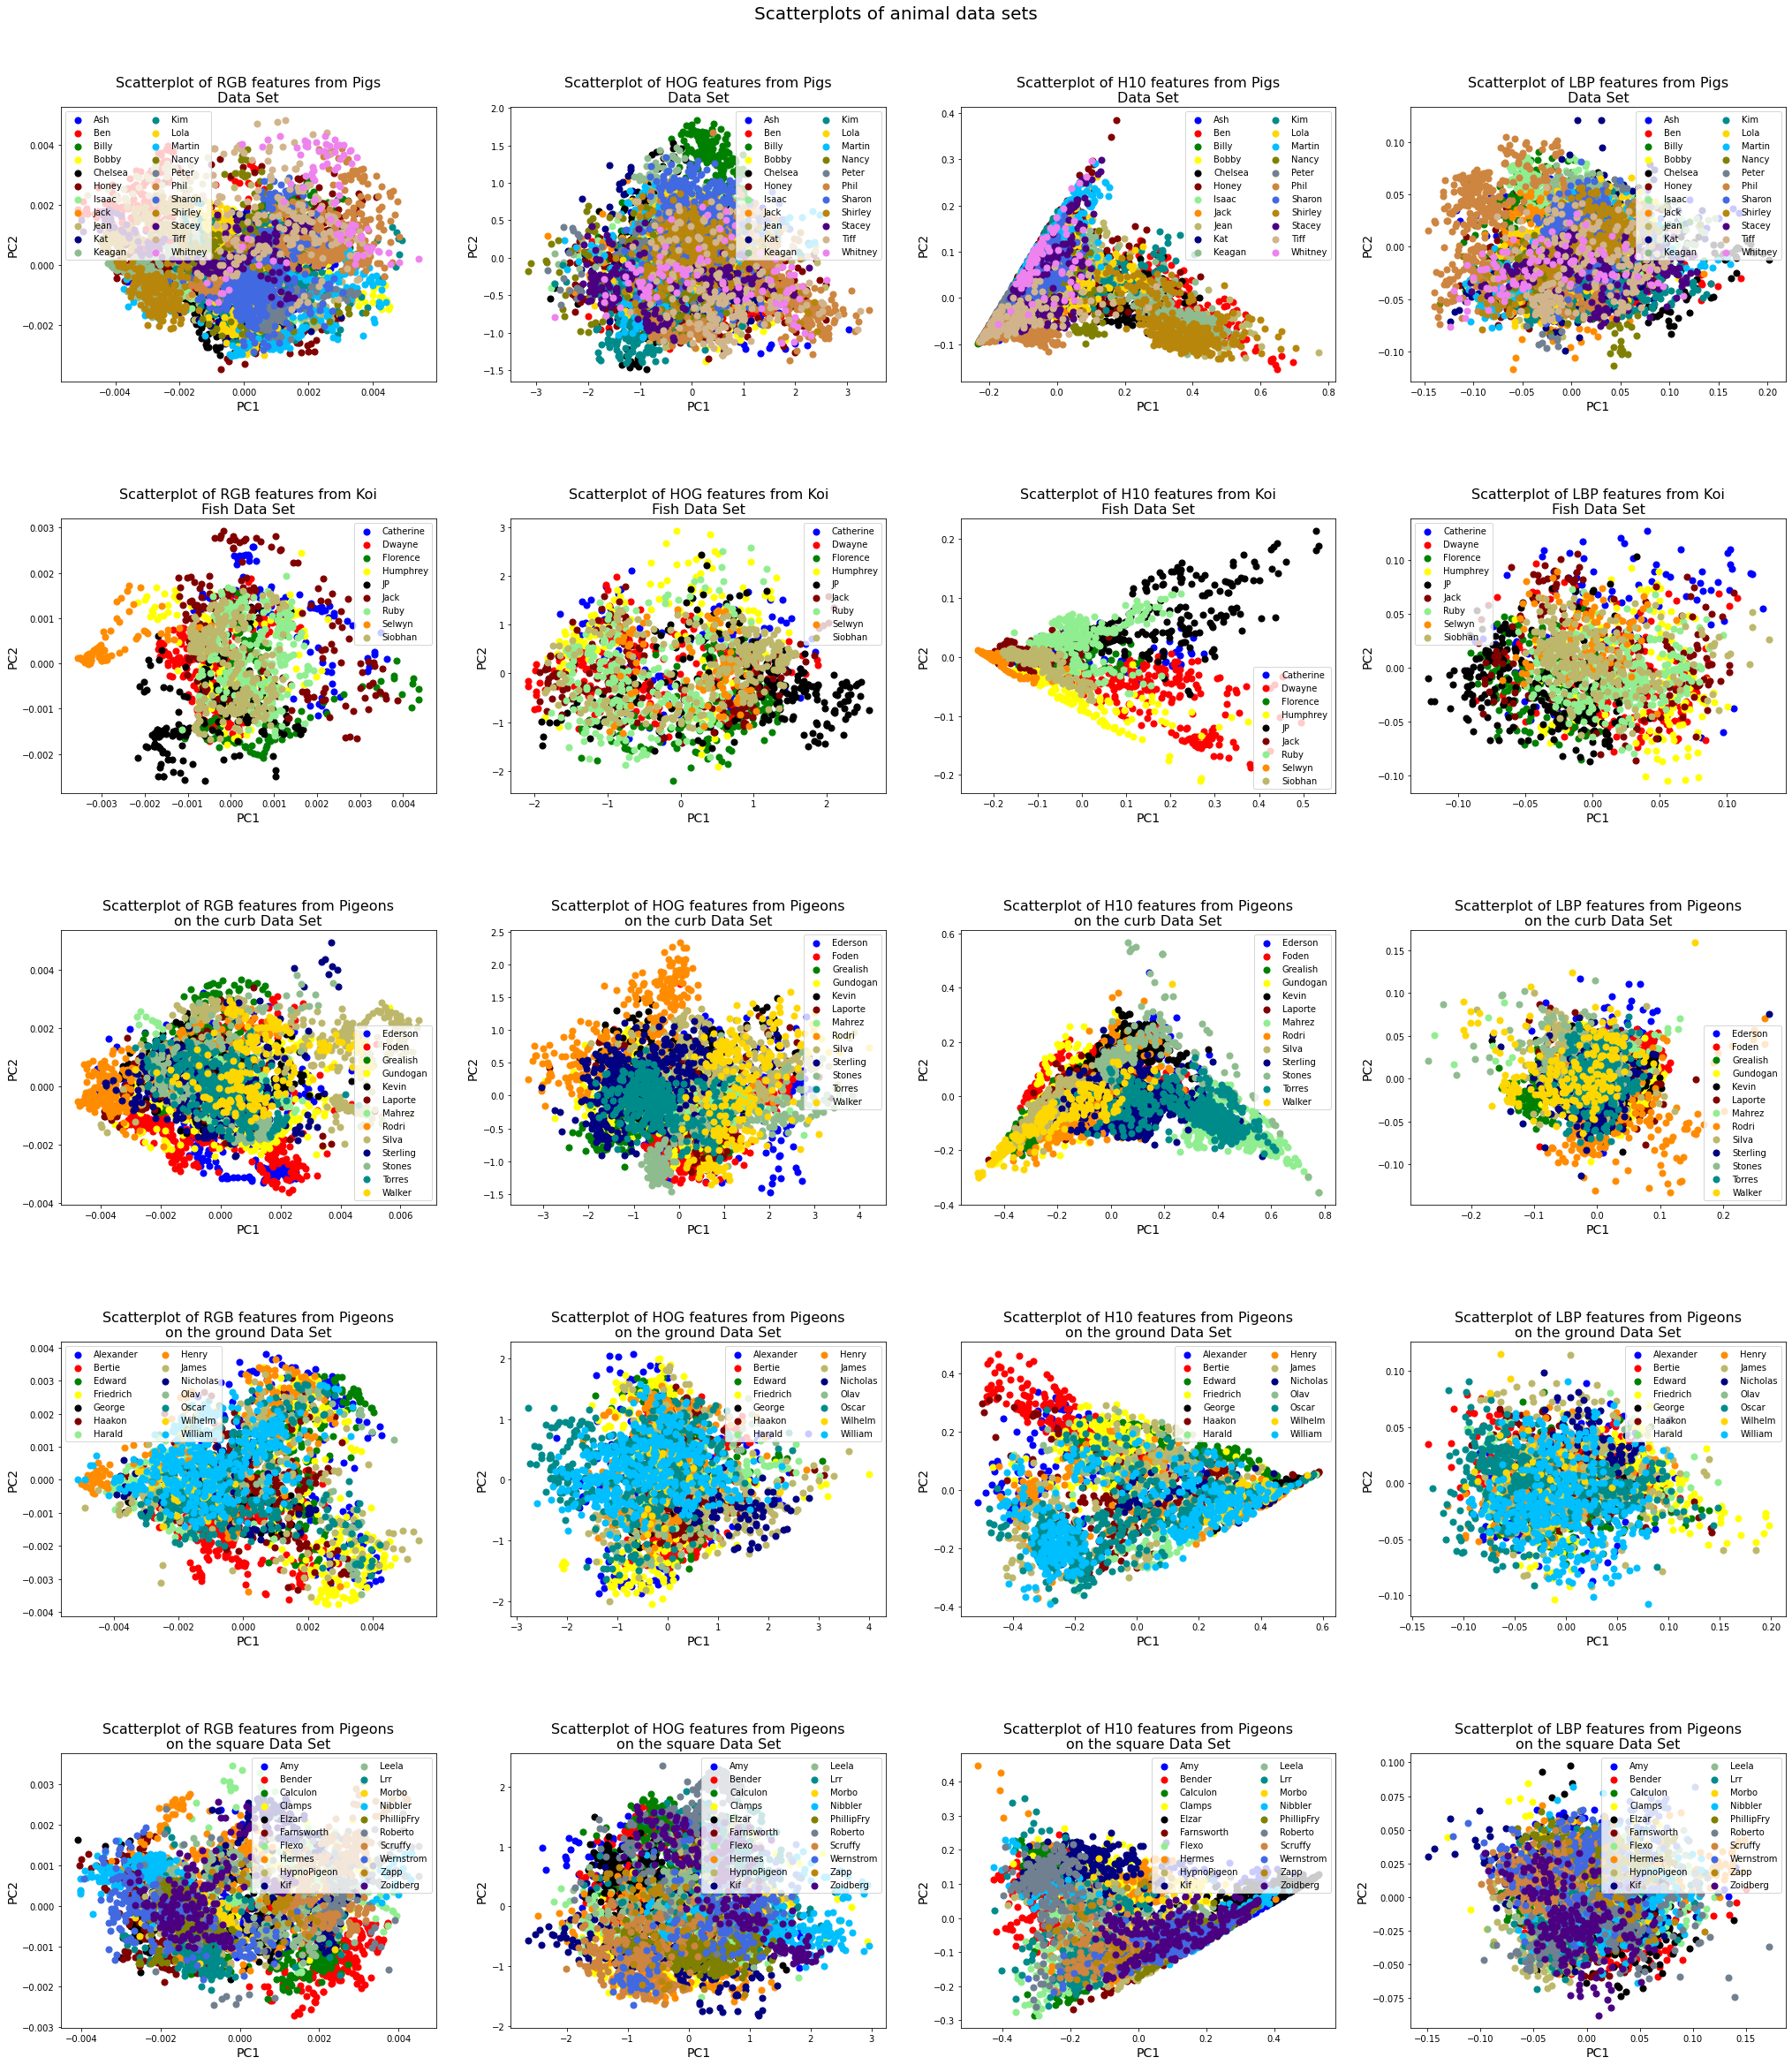

In [44]:
#Plotting scatterplots
figure, axs = plt.subplots(5, 4, figsize = (35,40))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Scatterplots of animal Datasets', fontsize = subp_title_size, y = 0.92)
n_comp = 2
symb_marker = 'o'

#Plotting scatterplots of Pigs

cls_names = pigs_lbl_names

Pigs_data_RGB_r = reduce_dimensionality(Pigs_data_RGB, n_comp) 

plot_scatterplot(Pigs_data_RGB_r, Pigs_labels, axs[0,0], 'Scatterplot of RGB features from Pigs Dataset', 
                cls_names, symb_marker, label_sizes)

Pigs_data_HOG_r = reduce_dimensionality(Pigs_data_HOG, n_comp) 

plot_scatterplot(Pigs_data_HOG_r, Pigs_labels, axs[0,1], 'Scatterplot of HOG features from Pigs Dataset', 
                cls_names, symb_marker, label_sizes)

Pigs_data_H10_r = reduce_dimensionality(Pigs_data_H10, n_comp) 

plot_scatterplot(Pigs_data_H10_r, Pigs_labels, axs[0,2], 'Scatterplot of H10 features from Pigs Dataset', 
                cls_names, symb_marker, label_sizes)

Pigs_data_LBP_r = reduce_dimensionality(Pigs_data_LBP, n_comp) 

plot_scatterplot(Pigs_data_LBP_r, Pigs_labels, axs[0,3], 'Scatterplot of LBP features from Pigs Dataset', 
                cls_names, symb_marker, label_sizes)

#Plotting scatterplots of Koi Fish
cls_names = koi_lbl_names

Koi_data_RGB_r = reduce_dimensionality(Koi_data_RGB, n_comp) 

plot_scatterplot(Koi_data_RGB_r, Koi_labels, axs[1,0], 'Scatterplot of RGB features from Koi Fish Dataset', 
                 cls_names, symb_marker, label_sizes)

Koi_data_HOG_r = reduce_dimensionality(Koi_data_HOG, n_comp) 

plot_scatterplot(Koi_data_HOG_r, Koi_labels, axs[1,1], 'Scatterplot of HOG features from Koi Fish Dataset', 
                 cls_names, symb_marker, label_sizes)

Koi_data_H10_r = reduce_dimensionality(Koi_data_H10, n_comp) 

plot_scatterplot(Koi_data_H10_r, Koi_labels, axs[1,2], 'Scatterplot of H10 features from Koi Fish Dataset', 
                 cls_names, symb_marker, label_sizes)

Koi_data_LBP_r = reduce_dimensionality(Koi_data_LBP, n_comp) 

plot_scatterplot(Koi_data_LBP_r, Koi_labels, axs[1,3], 'Scatterplot of LBP features from Koi Fish Dataset', 
                 cls_names, symb_marker, label_sizes)


#Plotting scatterplots of Pigeons on the curb

cls_names = pigeons_curb_lbl_names

Pigeons_curb_data_RGB_r = reduce_dimensionality(Pigeons_curb_data_RGB, n_comp) 

plot_scatterplot(Pigeons_curb_data_RGB_r, Pigeons_curb_labels, axs[2,0], 
                 'Scatterplot of RGB features from Pigeons on the curb Dataset', 
                 cls_names, symb_marker, label_sizes)

Pigeons_curb_data_HOG_r = reduce_dimensionality(Pigeons_curb_data_HOG, n_comp) 

plot_scatterplot(Pigeons_curb_data_HOG_r, Pigeons_curb_labels, axs[2,1], 
                 'Scatterplot of HOG features from Pigeons on the curb Dataset', 
                 cls_names, symb_marker, label_sizes)

Pigeons_curb_data_H10_r = reduce_dimensionality(Pigeons_curb_data_H10, n_comp) 

plot_scatterplot(Pigeons_curb_data_H10_r, Pigeons_curb_labels, axs[2,2], 
                 'Scatterplot of H10 features from Pigeons on the curb Dataset', 
                 cls_names, symb_marker, label_sizes)

Pigeons_curb_data_LBP_r = reduce_dimensionality(Pigeons_curb_data_LBP, n_comp) 

plot_scatterplot(Pigeons_curb_data_LBP_r, Pigeons_curb_labels, axs[2,3], 
                 'Scatterplot of LBP features from Pigeons on the curb Dataset', 
                 cls_names, symb_marker, label_sizes)

#Plotting scatterplots of Pigeons on the ground

cls_names = pigeons_ground_lbl_names

Pigeons_ground_data_RGB_r = reduce_dimensionality(Pigeons_ground_data_RGB, n_comp) 

plot_scatterplot(Pigeons_ground_data_RGB_r, Pigeons_ground_labels, axs[3,0], 
                 'Scatterplot of RGB features from Pigeons on the ground Dataset', 
                 cls_names, symb_marker, label_sizes)

Pigeons_ground_data_HOG_r = reduce_dimensionality(Pigeons_ground_data_HOG, n_comp) 

plot_scatterplot(Pigeons_ground_data_HOG_r, Pigeons_ground_labels, axs[3,1], 
                 'Scatterplot of HOG features from Pigeons on the ground Dataset', 
                 cls_names, symb_marker, label_sizes)

Pigeons_ground_data_H10_r = reduce_dimensionality(Pigeons_ground_data_H10, n_comp) 

plot_scatterplot(Pigeons_ground_data_H10_r, Pigeons_ground_labels, axs[3,2], 
                 'Scatterplot of H10 features from Pigeons on the ground Dataset', 
                 cls_names, symb_marker, label_sizes)

Pigeons_ground_data_LBP_r = reduce_dimensionality(Pigeons_ground_data_LBP, n_comp) 

plot_scatterplot(Pigeons_ground_data_LBP_r, Pigeons_ground_labels, axs[3,3], 
                 'Scatterplot of LBP features from Pigeons on the ground Dataset', 
                 cls_names, symb_marker, label_sizes)

#Plotting scatterplots of Pigeons on the square

cls_names = pigeons_square_lbl_names

Pigeons_square_data_RGB_r = reduce_dimensionality(Pigeons_square_data_RGB, n_comp) 

plot_scatterplot(Pigeons_square_data_RGB_r, Pigeons_square_labels, axs[4,0], 
                 'Scatterplot of RGB features from Pigeons on the square Dataset', 
                 cls_names, symb_marker, label_sizes)

Pigeons_square_data_HOG_r = reduce_dimensionality(Pigeons_square_data_HOG, n_comp) 

plot_scatterplot(Pigeons_square_data_HOG_r, Pigeons_square_labels, axs[4,1], 
                 'Scatterplot of HOG features from Pigeons on the square Dataset', 
                 cls_names, symb_marker, label_sizes)

Pigeons_square_data_H10_r = reduce_dimensionality(Pigeons_square_data_H10, n_comp) 

plot_scatterplot(Pigeons_square_data_H10_r, Pigeons_square_labels, axs[4,2], 
                 'Scatterplot of H10 features from Pigeons on the square Dataset', 
                 cls_names, symb_marker, label_sizes)

Pigeons_square_data_LBP_r = reduce_dimensionality(Pigeons_square_data_LBP, n_comp) 

plot_scatterplot(Pigeons_square_data_LBP_r, Pigeons_square_labels, axs[4,3], 
                 'Scatterplot of LBP features from Pigeons on the square Dataset', 
                 cls_names, symb_marker, label_sizes)


Run #  0
Run #  1
Time for pairwise clustering :7.0032  seconds


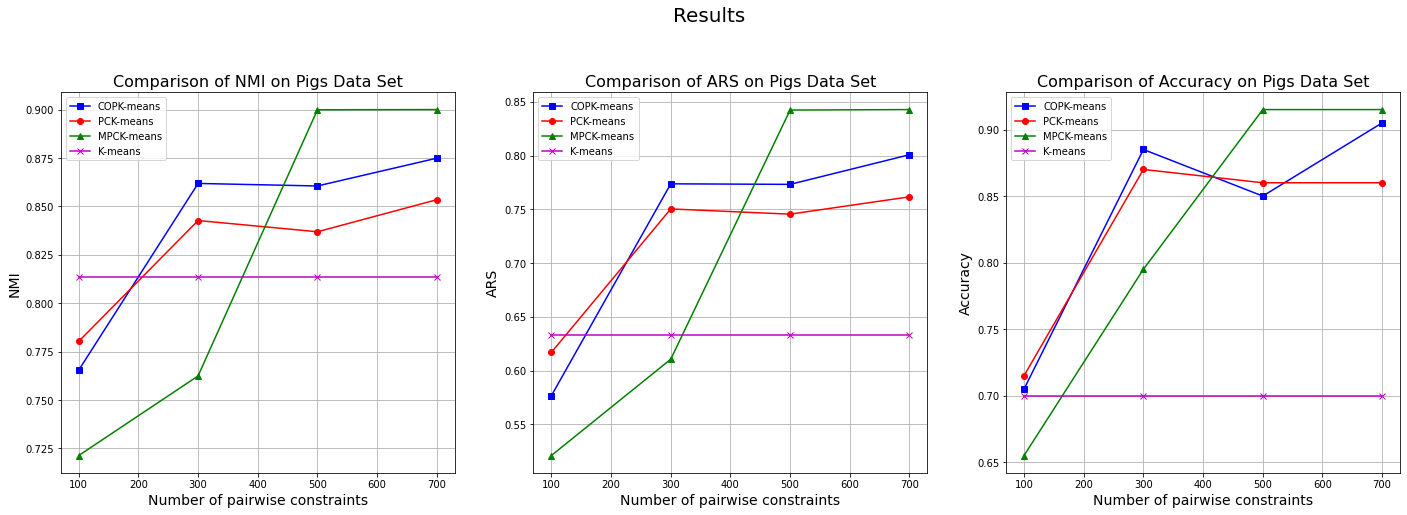

In [8]:
#Setting up sub-plots
figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Results', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigs Dataset - RGB features

titles = ['Comparison of NMI on Pigs Dataset', 'Comparison of ARS on Pigs Dataset', 
          'Comparison of Accuracy on Pigs Dataset']

Video_frames = Pigs_frames

s_time_clus = time()

n_comp = 10
Pigs_data_RGB_r = reduce_dimensionality(Pigs_data_RGB, n_comp) 

n_runs = 20
order_random = False
all_NMI, all_ARS, all_ACC = run_experiments(Pigs_data_RGB_r[:100], Pigs_labels[:100], Video_frames[:100], 
                                            arr_n_constraints, n_runs, order_random)


e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)


Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :4711.8084  seconds


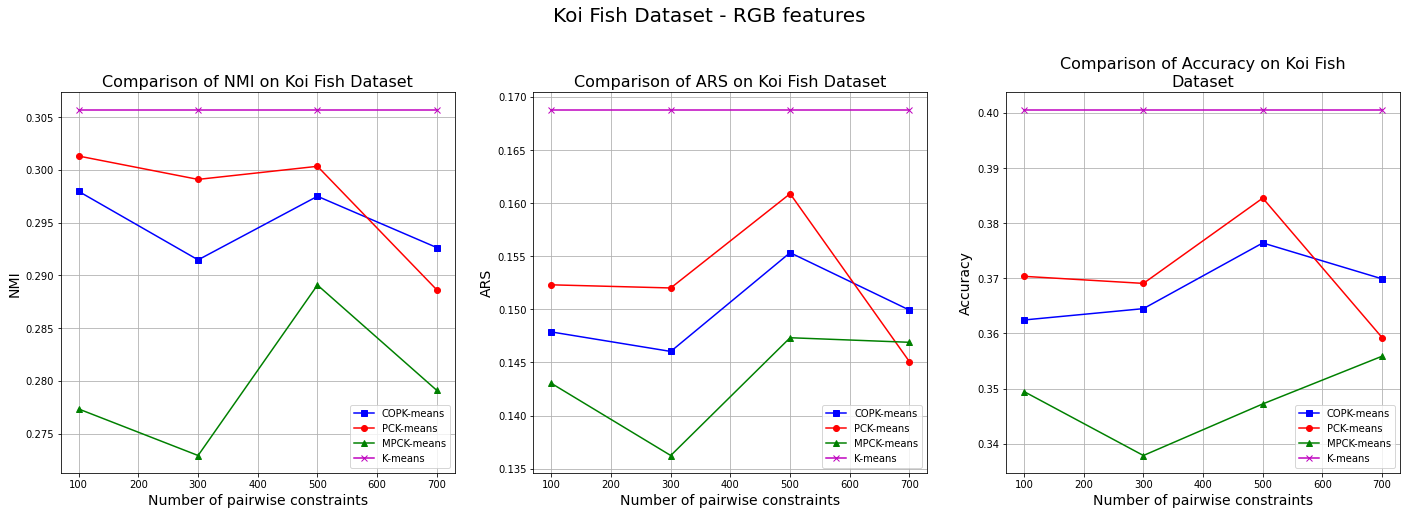

In [21]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Koi Fish Dataset - RGB features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Koi fish Dataset - RGB features
cls_names = koi_lbl_names
Video_frames = Koi_frames
titles = ['Comparison of NMI on Koi Fish Dataset', 
          'Comparison of ARS on Koi Fish Dataset', 
          'Comparison of Accuracy on Koi Fish Dataset']


s_time_clus = time()

n_comp = 10
Koi_data_RGB_r = reduce_dimensionality(Koi_data_RGB, n_comp) 

n_runs = 20
order_random = False
all_NMI, all_ARS, all_ACC = run_experiments(Koi_data_RGB_r, Koi_labels, Video_frames, 
                                            arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :73937.2883  seconds


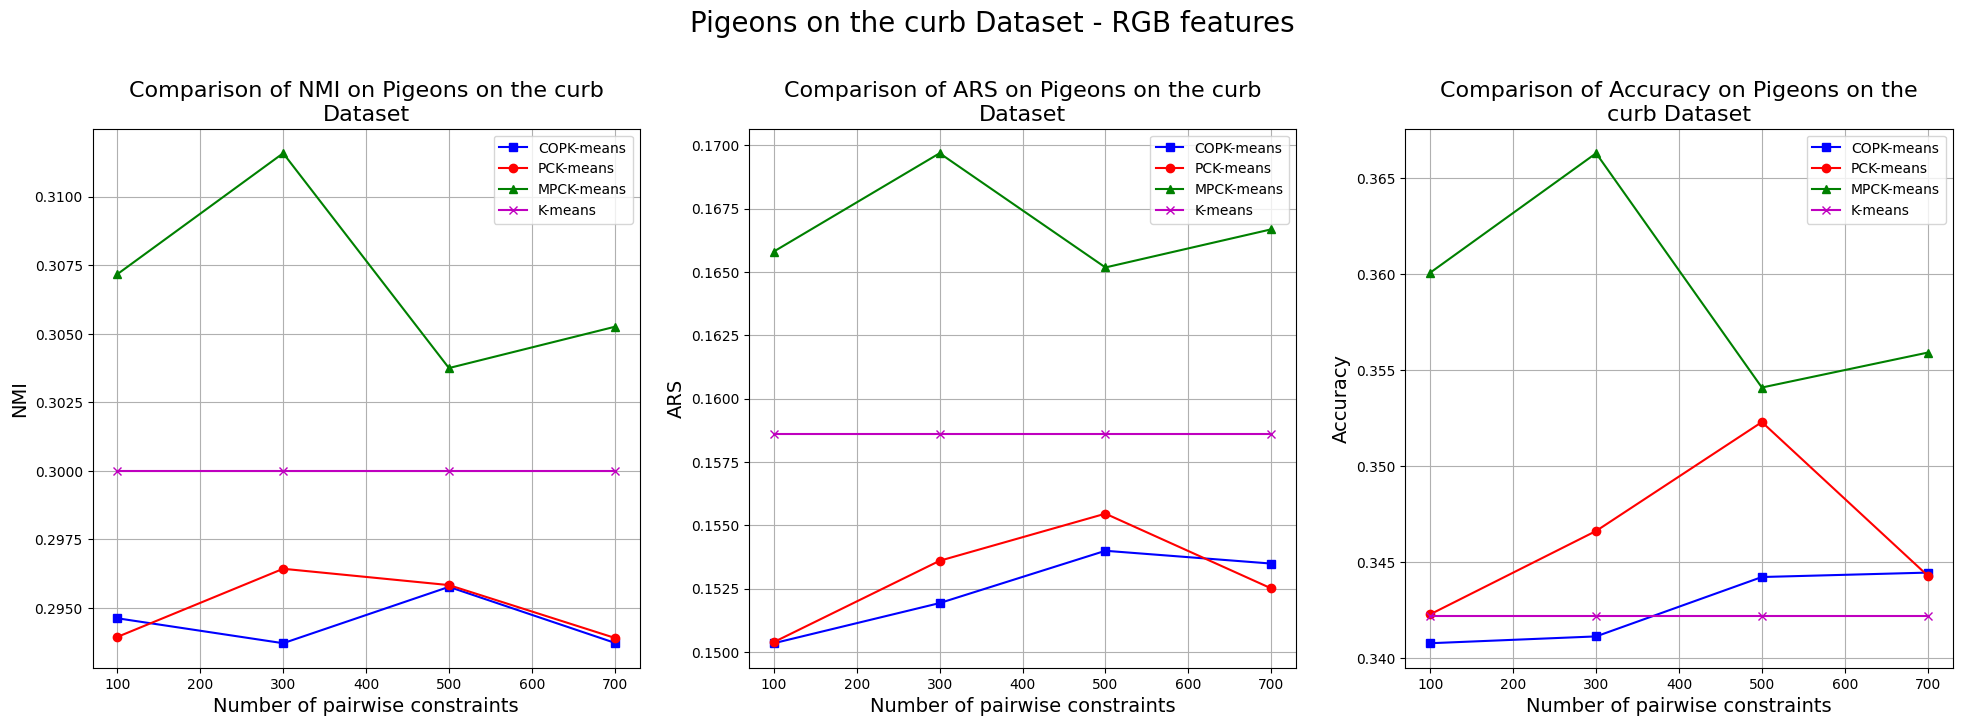

In [12]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the curb Dataset - RGB features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the curb Dataset

cls_names = pigeons_curb_lbl_names
titles = ['Comparison of NMI on Pigeons on the curb Dataset', 
          'Comparison of ARS on Pigeons on the curb Dataset', 
          'Comparison of Accuracy on Pigeons on the curb Dataset']

Video_frames = Pigeons_curb_frames

n_comp = 10
Pigeons_curb_data_RGB_r = reduce_dimensionality(Pigeons_curb_data_RGB, n_comp) 

s_time_clus = time()

n_runs = 20
order_random = False
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_curb_data_RGB_r, Pigeons_curb_labels, 
                                            Video_frames, arr_n_constraints, n_runs, order_random)


e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :3.4150  seconds


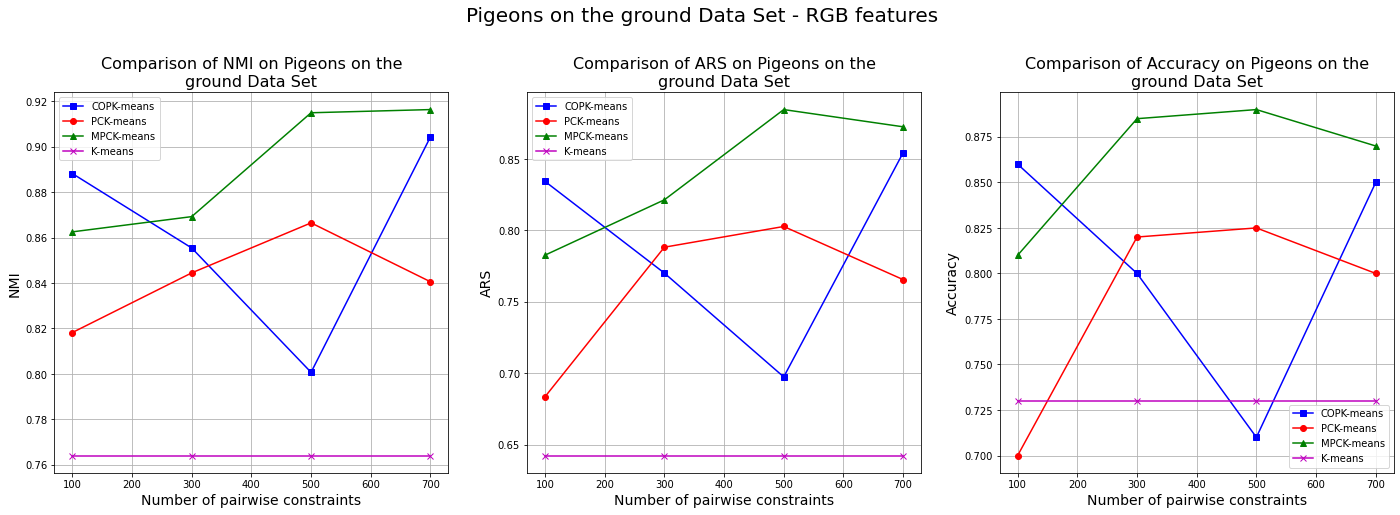

In [13]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the ground Dataset - RGB features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the ground Dataset

cls_names = pigeons_ground_lbl_names
titles = ['Comparison of NMI on Pigeons on the ground Dataset', 
          'Comparison of ARS on Pigeons on the ground Dataset', 
          'Comparison of Accuracy on Pigeons on the ground Dataset']

Video_frames = Pigeons_ground_frames

n_comp = 10
Pigeons_ground_data_RGB_r = reduce_dimensionality(Pigeons_ground_data_RGB, n_comp) 

s_time_clus = time()

n_runs = 2
order_random = False
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_ground_data_RGB[:100], Pigeons_ground_labels[:100], 
                                            Video_frames[:100], arr_n_constraints, n_runs, order_random)


e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :20.1263  seconds


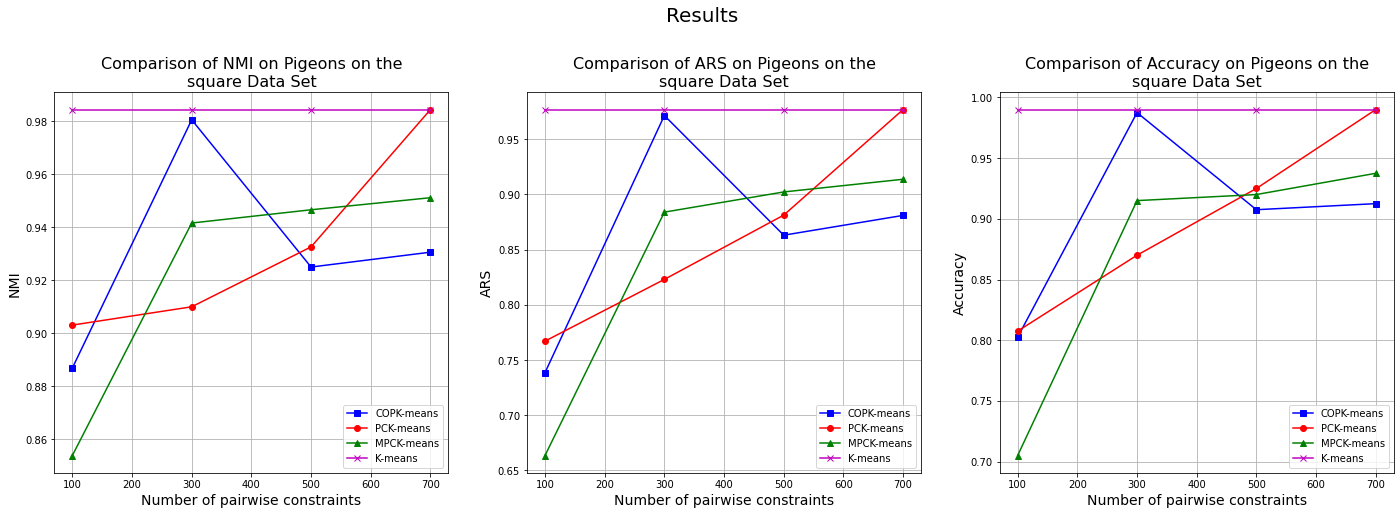

In [16]:
#Setting up sub-plots

figure, axs = plt.subplots(1,3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the square Dataset - RGB features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the square Dataset

cls_names = pigeons_square_lbl_names
titles = ['Comparison of NMI on Pigeons on the square Dataset', 
          'Comparison of ARS on Pigeons on the square Dataset', 
          'Comparison of Accuracy on Pigeons on the square Dataset']

Video_frames = Pigeons_square_frames

n_comp = 10
Pigeons_square_data_RGB_r = reduce_dimensionality(Pigeons_square_data_RGB, n_comp) 

s_time_clus = time()

n_runs = 2
order_random = False
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_square_data_RGB[:200], Pigeons_square_labels[:200], 
                                            Video_frames[:200], arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :5.6680  seconds


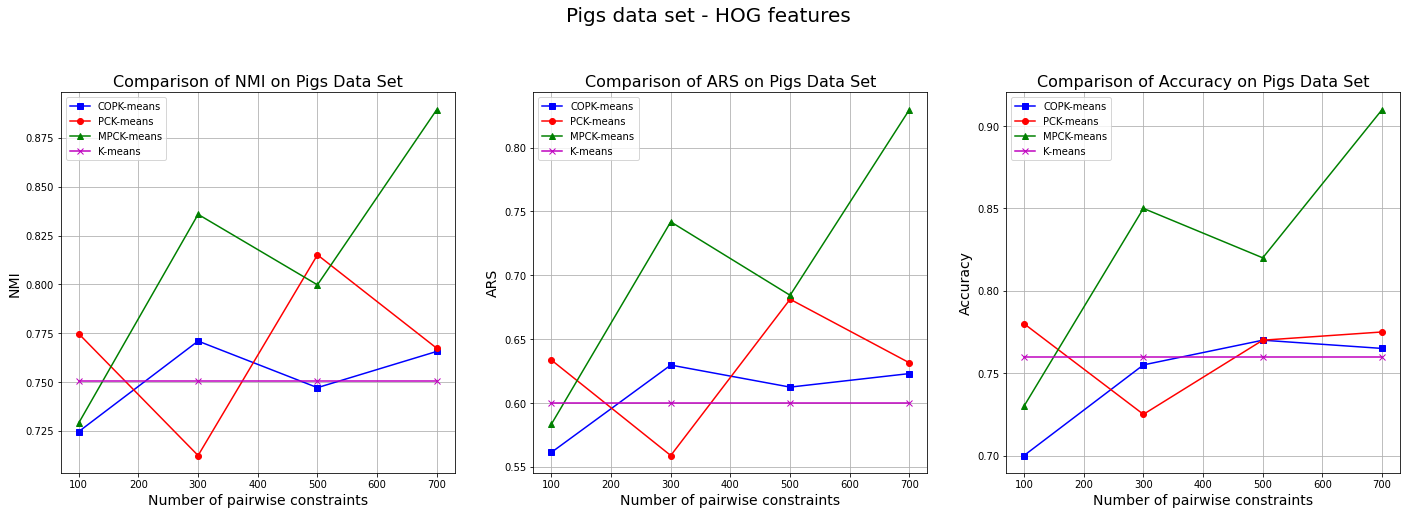

In [18]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigs Dataset - HOG features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigs Dataset - HOG feature representation

cls_names = pigs_lbl_names
Video_frames = Pigs_frames

titles = ['Comparison of NMI on Pigs Dataset', 
          'Comparison of ARS on Pigs Dataset', 
          'Comparison of Accuracy on Pigs Dataset']

n_comp = 10
Pigs_data_HOG_r = reduce_dimensionality(Pigs_data_HOG, n_comp) 

s_time_clus = time()

n_runs = 2
order_random = False
all_NMI, all_ARS, all_ACC = run_experiments(Pigs_data_HOG_r[:100], Pigs_labels[:100], Video_frames[:100], 
                                            arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :4699.9561  seconds


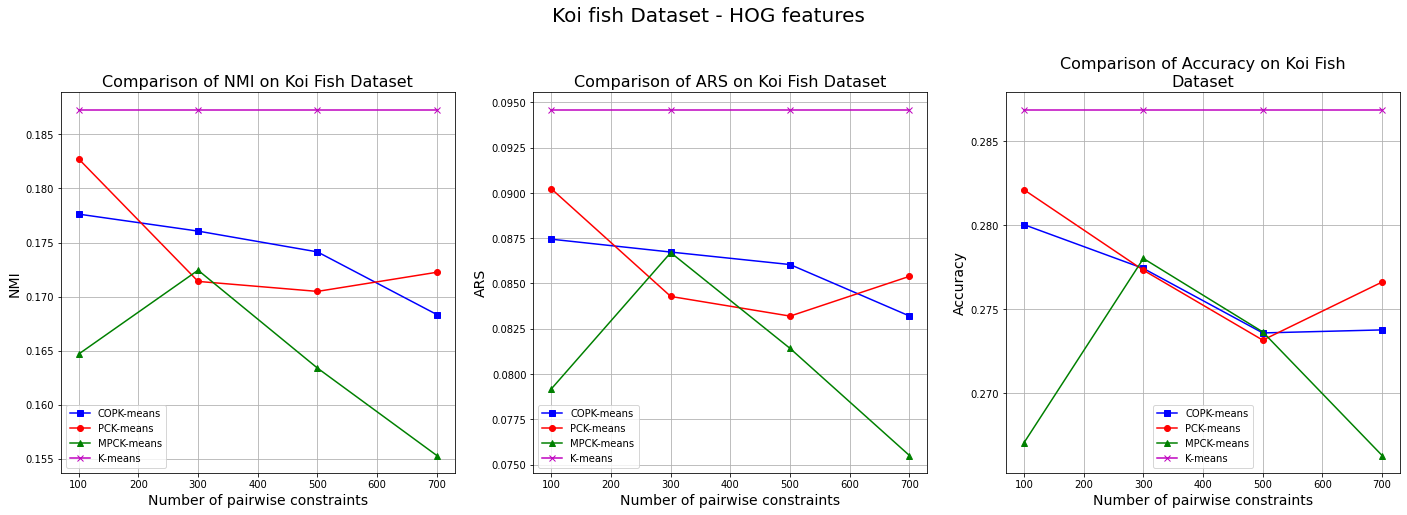

In [26]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Koi fish Dataset - HOG features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Koi fish Dataset - HOG feature representation

cls_names = koi_lbl_names
titles = ['Comparison of NMI on Koi Fish Dataset', 
          'Comparison of ARS on Koi Fish Dataset', 
          'Comparison of Accuracy on Koi Fish Dataset']

Video_frames = Koi_frames

n_comp = 10
Koi_data_HOG_r = reduce_dimensionality(Koi_data_HOG, n_comp) 

s_time_clus = time()

n_runs = 20
order_random = False
all_NMI, all_ARS, all_ACC = run_experiments(Koi_data_HOG_r, Koi_labels, Video_frames, 
                                            arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :7.8046  seconds


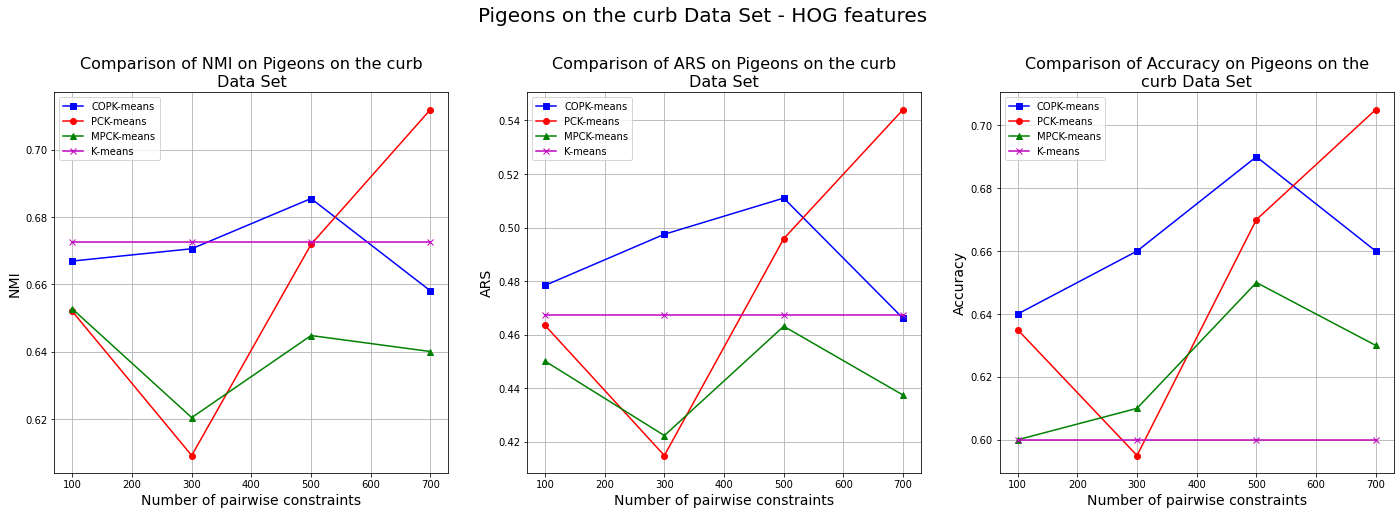

In [22]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the curb Dataset - HOG features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the curb Dataset - HOG feature representation

cls_names = pigeons_curb_lbl_names
titles = ['Comparison of NMI on Pigeons on the curb Dataset', 
          'Comparison of ARS on Pigeons on the curb Dataset', 
          'Comparison of Accuracy on Pigeons on the curb Dataset']

Video_frames = Pigeons_curb_frames

n_comp = 10
Pigeons_curb_data_HOG_r = reduce_dimensionality(Pigeons_curb_data_HOG, n_comp) 

s_time_clus = time()

n_runs = 2
order_random = False
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_curb_data_HOG_r[:100], Pigeons_curb_labels[:100], Video_frames[:100], 
                                            arr_n_constraints, n_runs, order_random)


e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :3.3693  seconds


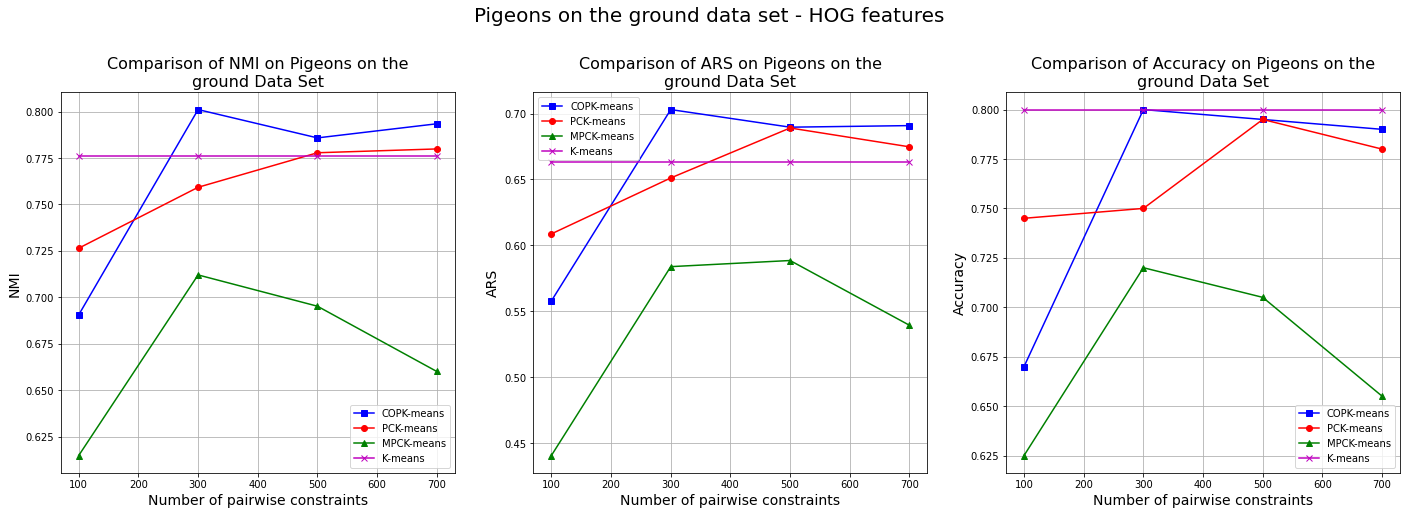

In [23]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the ground Dataset - HOG features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the ground Dataset - HOG feature representation

cls_names = pigeons_ground_lbl_names
titles = ['Comparison of NMI on Pigeons on the ground Dataset', 
          'Comparison of ARS on Pigeons on the ground Dataset', 
          'Comparison of Accuracy on Pigeons on the ground Dataset']

Video_frames = Pigeons_ground_frames

n_comp = 10
Pigeons_ground_data_HOG_r = reduce_dimensionality(Pigeons_ground_data_HOG, n_comp) 

s_time_clus = time()

n_runs = 2
order_random = False
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_ground_data_HOG_r[:100], Pigeons_ground_labels[:100], Video_frames[:100], 
                                            arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :3.0234  seconds


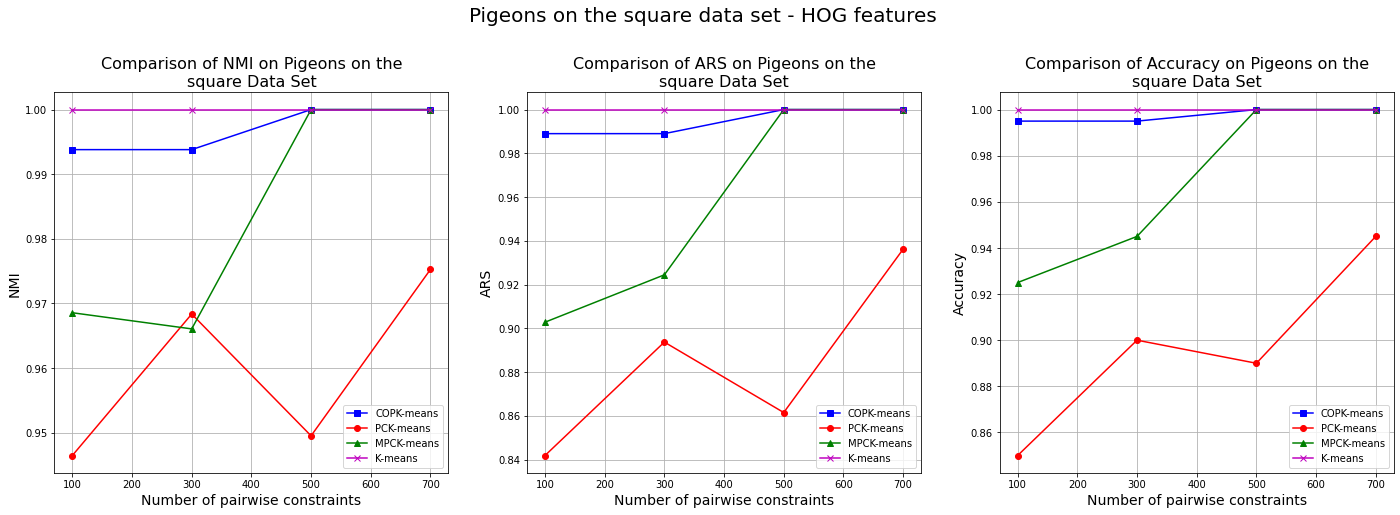

In [24]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the square Dataset - HOG features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the square Dataset - HOG feature representation

cls_names = pigeons_square_lbl_names
Video_frames = Pigeons_square_frames
titles = ['Comparison of NMI on Pigeons on the square Dataset', 
          'Comparison of ARS on Pigeons on the square Dataset', 
          'Comparison of Accuracy on Pigeons on the square Dataset']

n_comp = 10
Pigeons_square_data_HOG_r = reduce_dimensionality(Pigeons_square_data_HOG, n_comp) 

s_time_clus = time()

order_random = False
n_runs = 2
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_square_data_HOG_r[:100], Pigeons_square_labels[:100], 
                                            Video_frames[:100], arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :7.6137  seconds


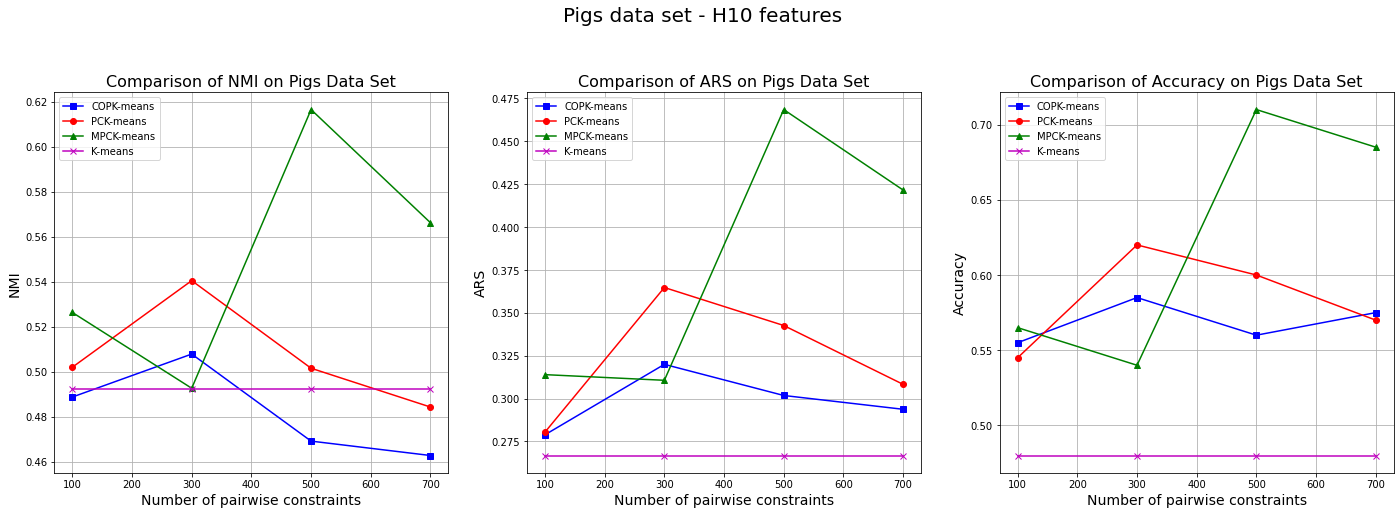

In [26]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigs Dataset - H10 features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigs Dataset - H10 feature representation

cls_names = pigs_lbl_names
titles = ['Comparison of NMI on Pigs Dataset', 'Comparison of ARS on Pigs Dataset', 
          'Comparison of Accuracy on Pigs Dataset']

Video_frames = Pigs_frames


s_time_clus = time()

order_random = False
n_runs = 2
all_NMI, all_ARS, all_ACC = run_experiments(Pigs_data_H10[:100], Pigs_labels[:100], 
                                            Video_frames[:100], arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :10636.2315  seconds


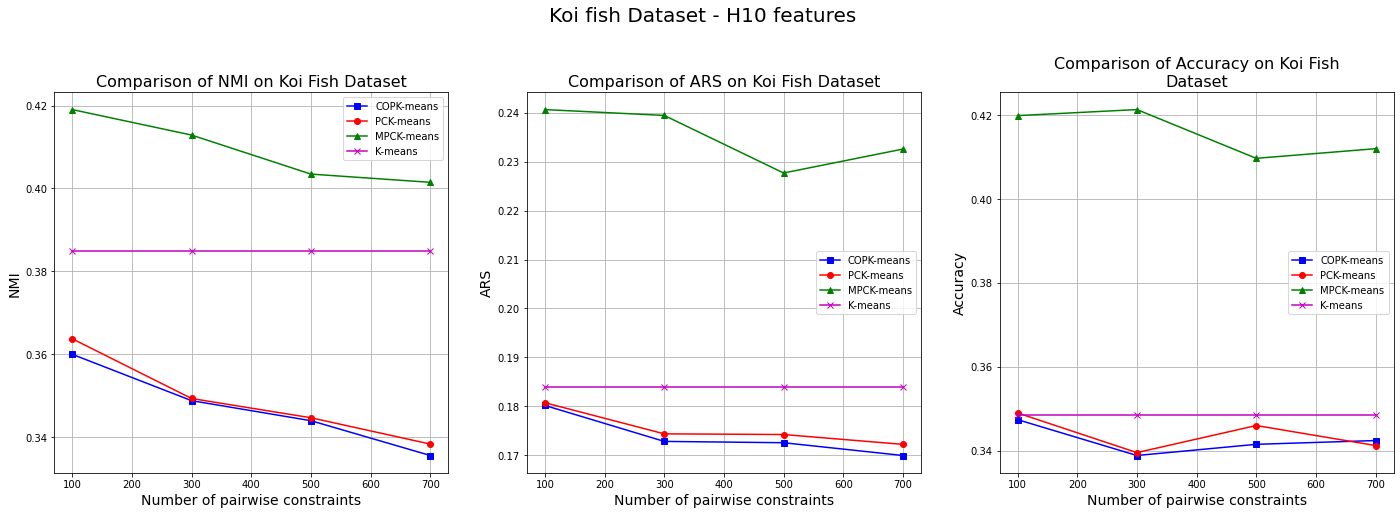

In [27]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Koi fish Dataset - H10 features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Koi fish Dataset - H10 feature representation

cls_names = koi_lbl_names
titles = ['Comparison of NMI on Koi Fish Dataset', 
          'Comparison of ARS on Koi Fish Dataset', 
          'Comparison of Accuracy on Koi Fish Dataset']

Video_frames = Koi_frames


s_time_clus = time()

order_random = False
n_runs = 20
all_NMI, all_ARS, all_ACC = run_experiments(Koi_data_H10, Koi_labels, 
                                            Video_frames, arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :8.3173  seconds


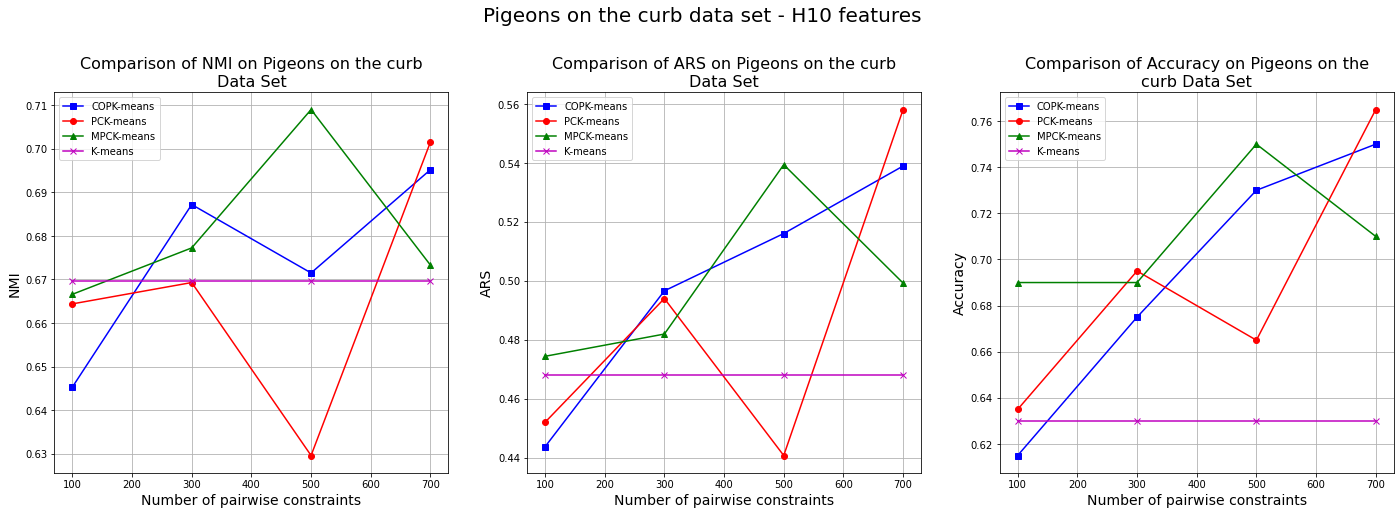

In [29]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the curb Dataset - H10 features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the curb Dataset - H10 feature representation

cls_names = pigeons_curb_lbl_names
titles = ['Comparison of NMI on Pigeons on the curb Dataset', 
          'Comparison of ARS on Pigeons on the curb Dataset', 
          'Comparison of Accuracy on Pigeons on the curb Dataset']

Video_frames = Pigeons_curb_frames

s_time_clus = time()

order_random = False
n_runs = 2
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_curb_data_H10[:100], Pigeons_curb_labels[:100], 
                                            Video_frames[:100], arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :7.2564  seconds


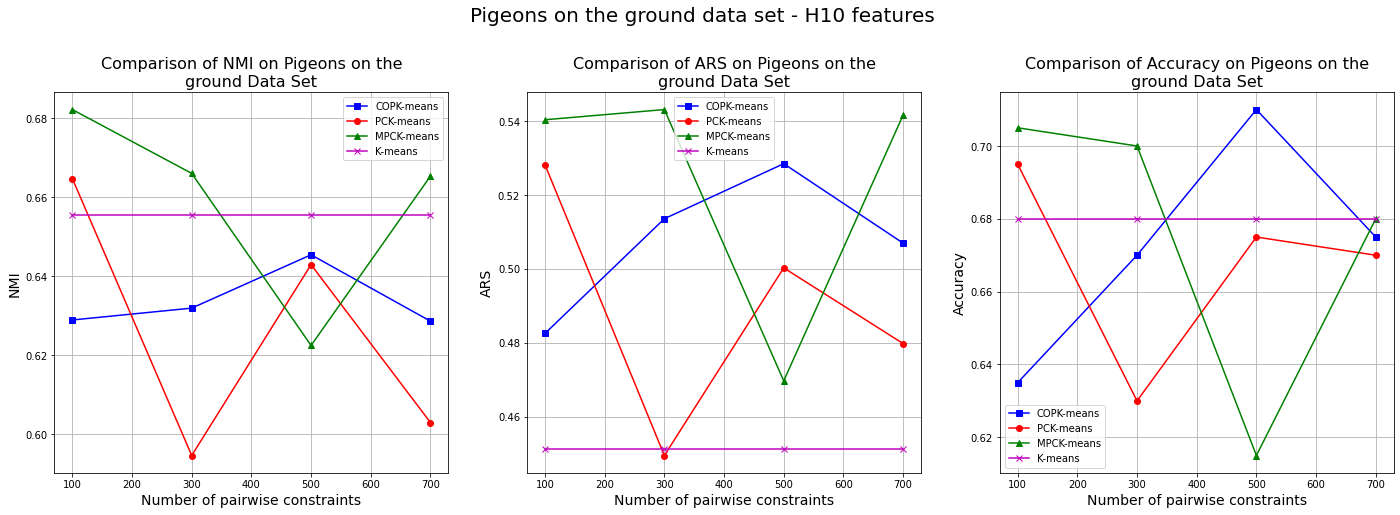

In [30]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the ground Dataset - H10 features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the ground Dataset - H10 feature representation

cls_names = pigeons_ground_lbl_names
titles = ['Comparison of NMI on Pigeons on the ground Dataset', 
          'Comparison of ARS on Pigeons on the ground Dataset', 
          'Comparison of Accuracy on Pigeons on the ground Dataset']

Video_frames = Pigeons_ground_frames

s_time_clus = time()

order_random = False
n_runs = 2
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_ground_data_H10[:100], Pigeons_ground_labels[:100], 
                                            Video_frames[:100], arr_n_constraints, n_runs, order_random)


e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :21.1553  seconds


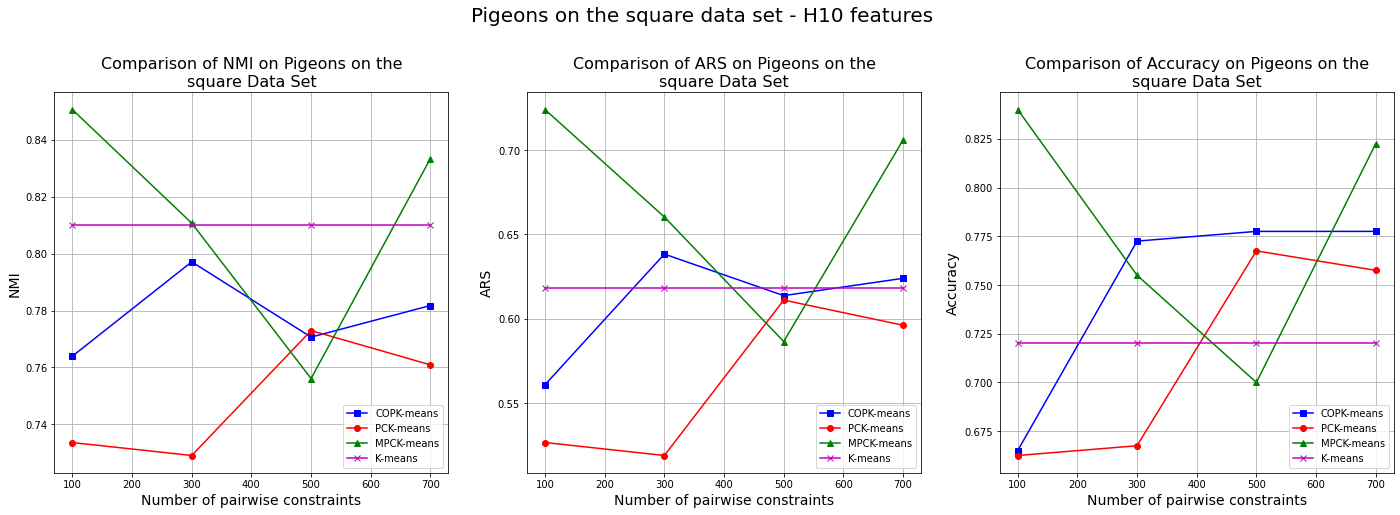

In [34]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the square Dataset - H10 features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the square Dataset - H10 feature representation

cls_names = pigeons_square_lbl_names
titles = ['Comparison of NMI on Pigeons on the square Dataset', 
          'Comparison of ARS on Pigeons on the square Dataset', 
          'Comparison of Accuracy on Pigeons on the square Dataset']

Video_frames = Pigeons_square_frames

s_time_clus = time()

order_random = False
n_runs = 2
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_square_data_H10[:200], Pigeons_square_labels[:200], 
                                            Video_frames[:200], arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :7.4712  seconds


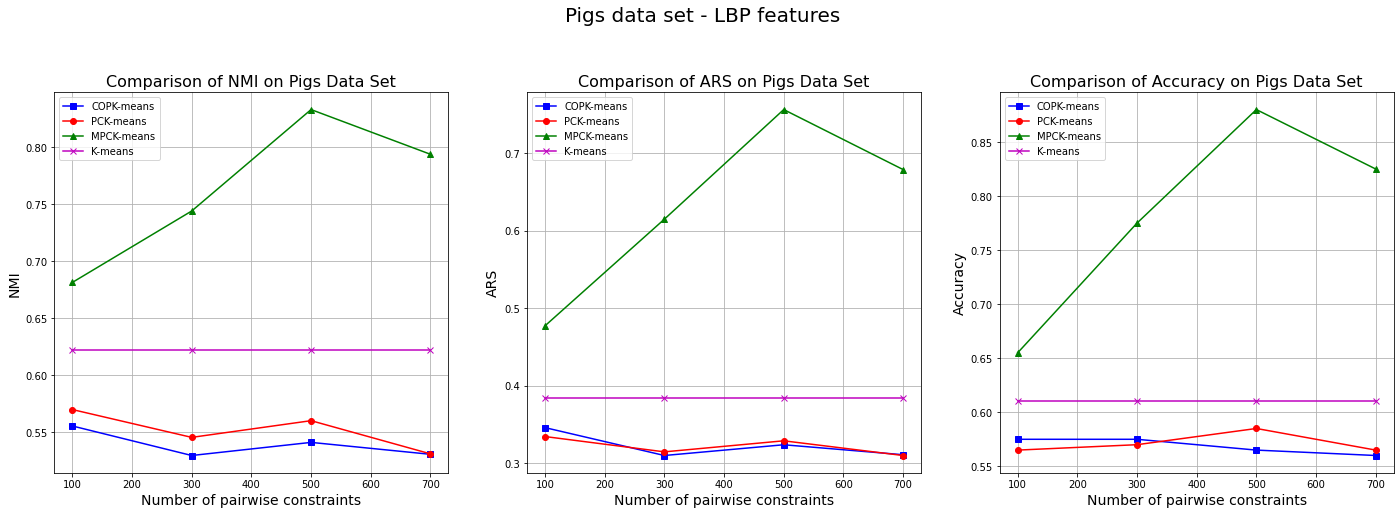

In [35]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigs Dataset - LBP features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigs Dataset - LBP feature representation

cls_names = pigs_lbl_names
titles = ['Comparison of NMI on Pigs Dataset', 'Comparison of ARS on Pigs Dataset', 
          'Comparison of Accuracy on Pigs Dataset']

Video_frames = Pigs_frames

n_comp = 10
Pigs_data_LBP_r = reduce_dimensionality(Pigs_data_LBP, n_comp) 


s_time_clus = time()

order_random = False
n_runs = 2
all_NMI, all_ARS, all_ACC = run_experiments(Pigs_data_LBP_r[:100], Pigs_labels[:100], 
                                            Video_frames[:100], arr_n_constraints, n_runs, order_random)


e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Run #  2
Run #  3
Run #  4
Run #  5
Run #  6
Run #  7
Run #  8
Run #  9
Run #  10
Run #  11
Run #  12
Run #  13
Run #  14
Run #  15
Run #  16
Run #  17
Run #  18
Run #  19
Time for pairwise clustering :14347.8184  seconds


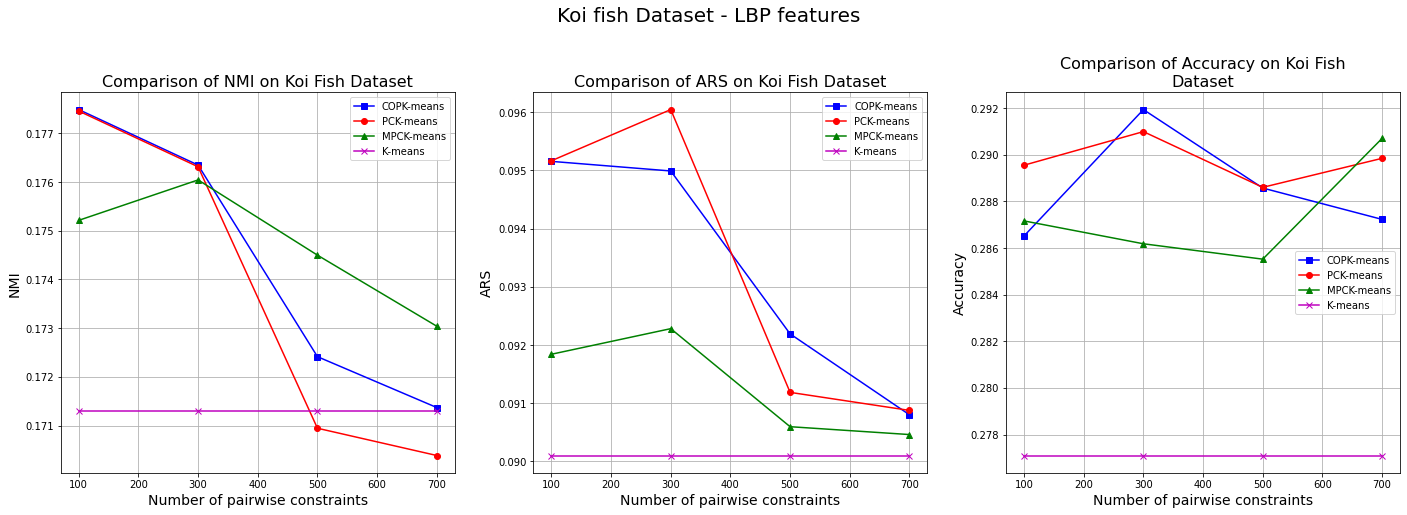

In [29]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Koi fish Dataset - LBP features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Koi fish Dataset - LBP feature representation

cls_names = koi_lbl_names
titles = ['Comparison of NMI on Koi Fish Dataset', 
          'Comparison of ARS on Koi Fish Dataset', 
          'Comparison of Accuracy on Koi Fish Dataset']

Video_frames = Koi_frames

n_comp = 10
Koi_data_LBP_r = reduce_dimensionality(Koi_data_LBP, n_comp) 


s_time_clus = time()

order_random = False
n_runs = 20
all_NMI, all_ARS, all_ACC = run_experiments(Koi_data_LBP_r, Koi_labels, 
                                            Video_frames, arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :8.6201  seconds


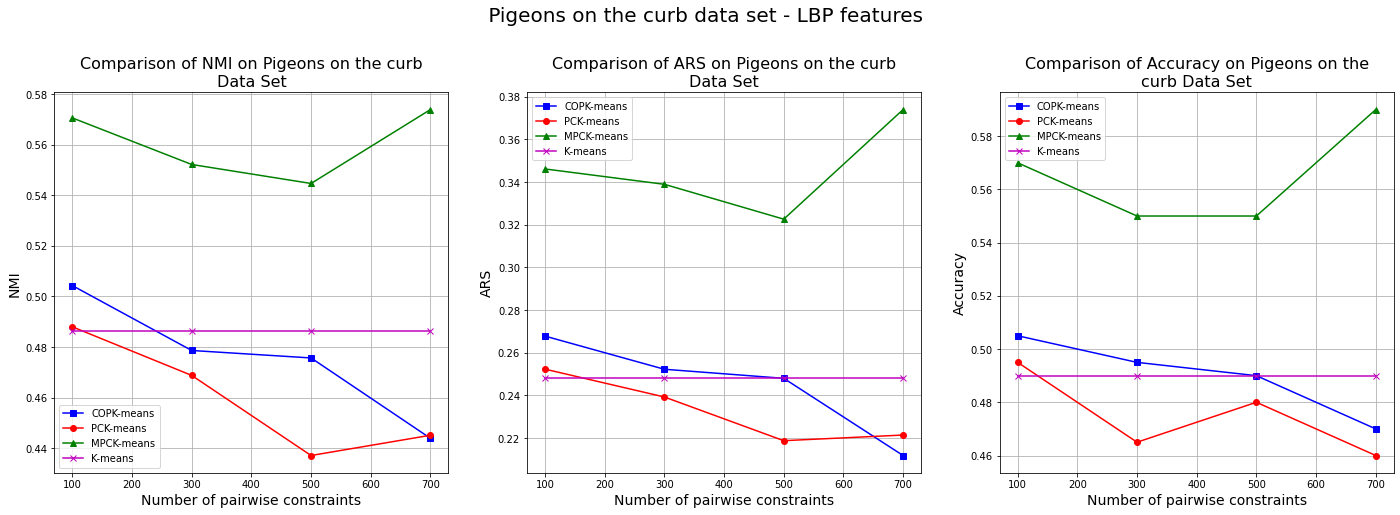

In [37]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle(' Pigeons on the curb Dataset - LBP features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the curb Dataset - LBP feature representation

cls_names = pigeons_curb_lbl_names
titles = ['Comparison of NMI on Pigeons on the curb Dataset', 
          'Comparison of ARS on Pigeons on the curb Dataset', 
          'Comparison of Accuracy on Pigeons on the curb Dataset']

Video_frames = Pigeons_curb_frames

n_comp = 10
Pigeons_curb_data_LBP_r = reduce_dimensionality(Pigeons_curb_data_LBP, n_comp) 


s_time_clus = time()

order_random = False
n_runs = 2
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_curb_data_LBP_r[:100], Pigeons_curb_labels[:100], 
                                            Video_frames[:100], arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :6.9166  seconds


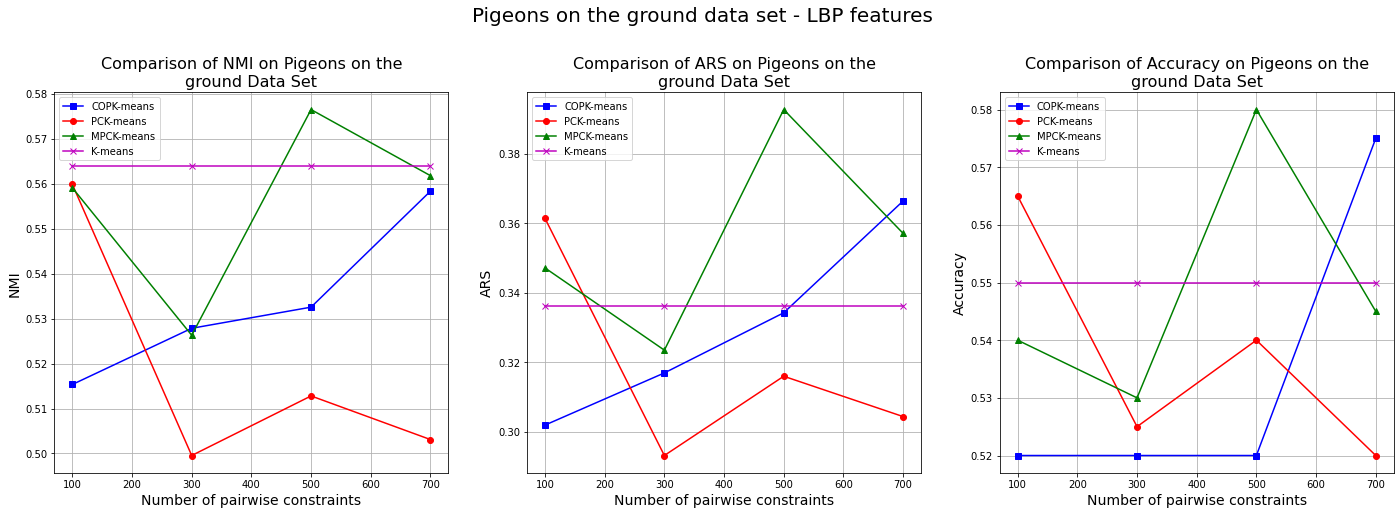

In [38]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the ground Dataset - LBP features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the ground Dataset - LBP feature representation

cls_names = pigeons_ground_lbl_names
titles = ['Comparison of NMI on Pigeons on the ground Dataset', 
          'Comparison of ARS on Pigeons on the ground Dataset', 
          'Comparison of Accuracy on Pigeons on the ground Dataset']

Video_frames = Pigeons_ground_frames

n_comp = 10
Pigeons_ground_data_LBP_r = reduce_dimensionality(Pigeons_ground_data_LBP, n_comp) 


s_time_clus = time()

order_random = False
n_runs = 2
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_ground_data_LBP_r[:100], Pigeons_ground_labels[:100], 
                                            Video_frames[:100], arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")

plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)

Run #  0
Run #  1
Time for pairwise clustering :8.0970  seconds


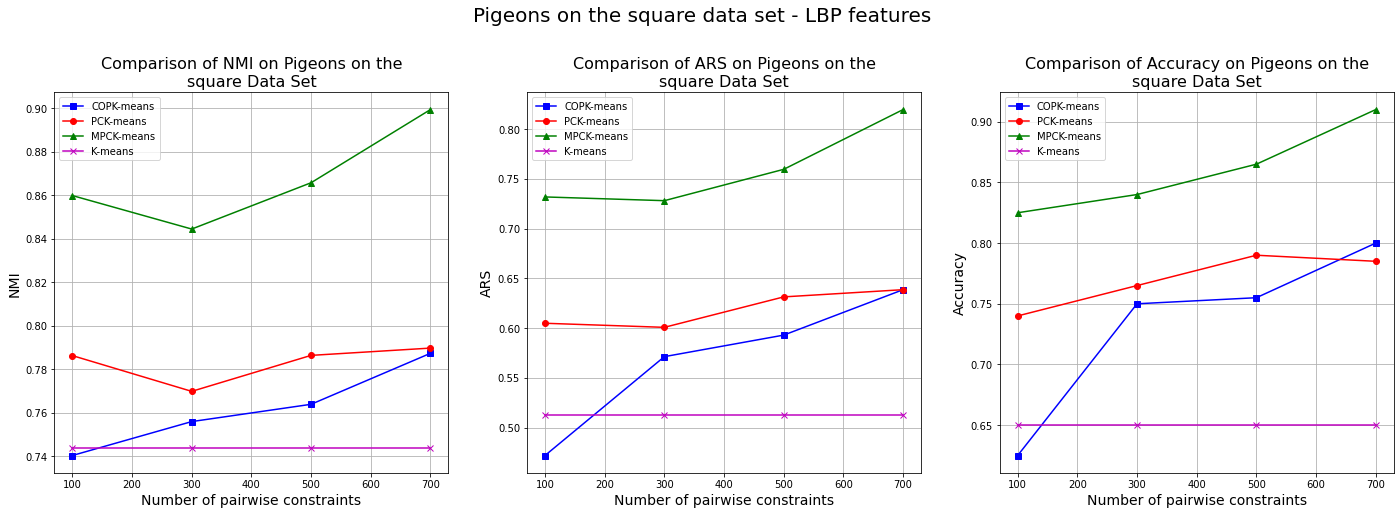

In [39]:
#Setting up sub-plots

figure, axs = plt.subplots(1, 3, figsize = (subp_width,subp_height))
plt.subplots_adjust(hspace = subp_hspace) 
plt.suptitle('Pigeons on the square Dataset - LBP features', fontsize = subp_title_size, y = y_title)

#Pairwise clustering of Pigeons on the square Dataset - LBP feature representation

cls_names = pigeons_square_lbl_names
titles = ['Comparison of NMI on Pigeons on the square Dataset', 
          'Comparison of ARS on Pigeons on the square Dataset', 
          'Comparison of Accuracy on Pigeons on the square Dataset']

Video_frames = Pigeons_square_frames

n_comp = 10
Pigeons_square_data_LBP_r = reduce_dimensionality(Pigeons_square_data_LBP, n_comp) 


s_time_clus = time()

order_random = False
n_runs = 2
all_NMI, all_ARS, all_ACC = run_experiments(Pigeons_square_data_LBP_r[:100], Pigeons_square_labels[:100], 
                                            Video_frames[:100], arr_n_constraints, n_runs, order_random)

e_time_clus = time()

print("Time for pairwise clustering :{:.4f} ".format(e_time_clus-s_time_clus), "seconds")
    
plot_NMI(all_NMI, titles[0], axs[0], label_sizes)
plot_ARS(all_ARS, titles[1], axs[1], label_sizes)
plot_ACC(all_ACC, titles[2], axs[2], label_sizes)